In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

base_path = r"D:\Extra datasets\brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0\100001\100001"
ecg_path = base_path + r"_ECG"


In [15]:
def ann_reader(path):
    # Load annotations
    raw = pd.read_csv(path, sep=',', engine="python", header=None)
    # Optionally set column names if you know them, e.g.:
    # raw.columns = ["start1", "end1", "val1", ..., "start4", "end4", "val4"]

    for c in raw.columns:
        raw[c] = pd.to_numeric(raw[c], errors="coerce")
        if pd.api.types.is_float_dtype(raw[c]):
            if (raw[c].dropna() % 1 == 0).all():
                raw[c] = raw[c].astype('Int64')

    starts = raw.iloc[:, 9].dropna()   # 10.,11.,12. kolonne = consensus (0-baseret: 9,10,11)
    ends   = raw.iloc[:,10].dropna()
    label_segments = raw.iloc[:,11].dropna()

    # Convert the loaded data
    labels_sample = []
    for start, end, label in zip(starts, ends, label_segments):
        if pd.isna(start) or pd.isna(end) or pd.isna(label):
            continue
        # For each segment, fill a list with the value for each index in the range [start, end]
        labels_sample.extend([int(label)] * (int(end) - int(start) + 1))

    # Create a 2D vector (list of tuples) with (start, end) pairs
    segments = list(zip(starts, ends))
    # # Validation of loaded annotations

    # print(labels[0])
    # print(starts[0])
    # print(ends[0])

    # print(len(segments))  # Total length of the segments list
    # print(segments[100:])  # Print the first 100 values to verify

    return labels_sample, starts, ends, label_segments, segments

In [ ]:
ann, starts, ends, labels, segments = ann_reader(base_path + r"_ANN.csv")
# print(len(ann))
# print(len(starts))
# print(len(ends))
# print(len(labels))
# print(len(segments))
# print(segments[0:10])

87087000
763
763
763
763


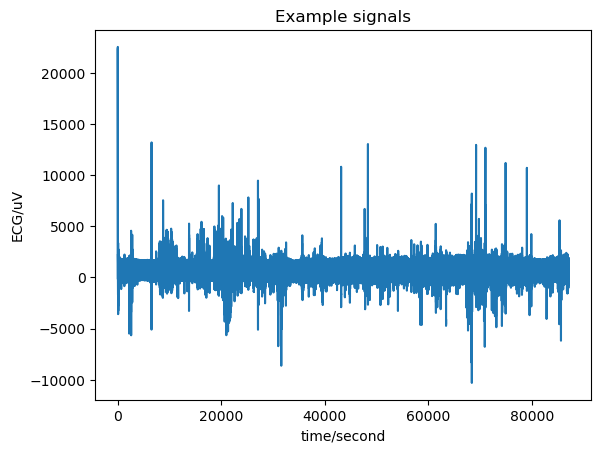

In [6]:
# load a record using the 'rdrecord' function
record = wfdb.rdrecord(ecg_path)

# plot the record to screen
wfdb.plot_wfdb(record=record, title='Example signals')

In [7]:
# Validation of loaded record, compare with raw load online: https://physionet.org/lightwave/?db=butqdb/1.0.0
# print(record.p_signal[:20] if record.p_signal is not None else record.d_signal[:20])
fs = record.fs  # Sampling frequency
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 1000 Hz


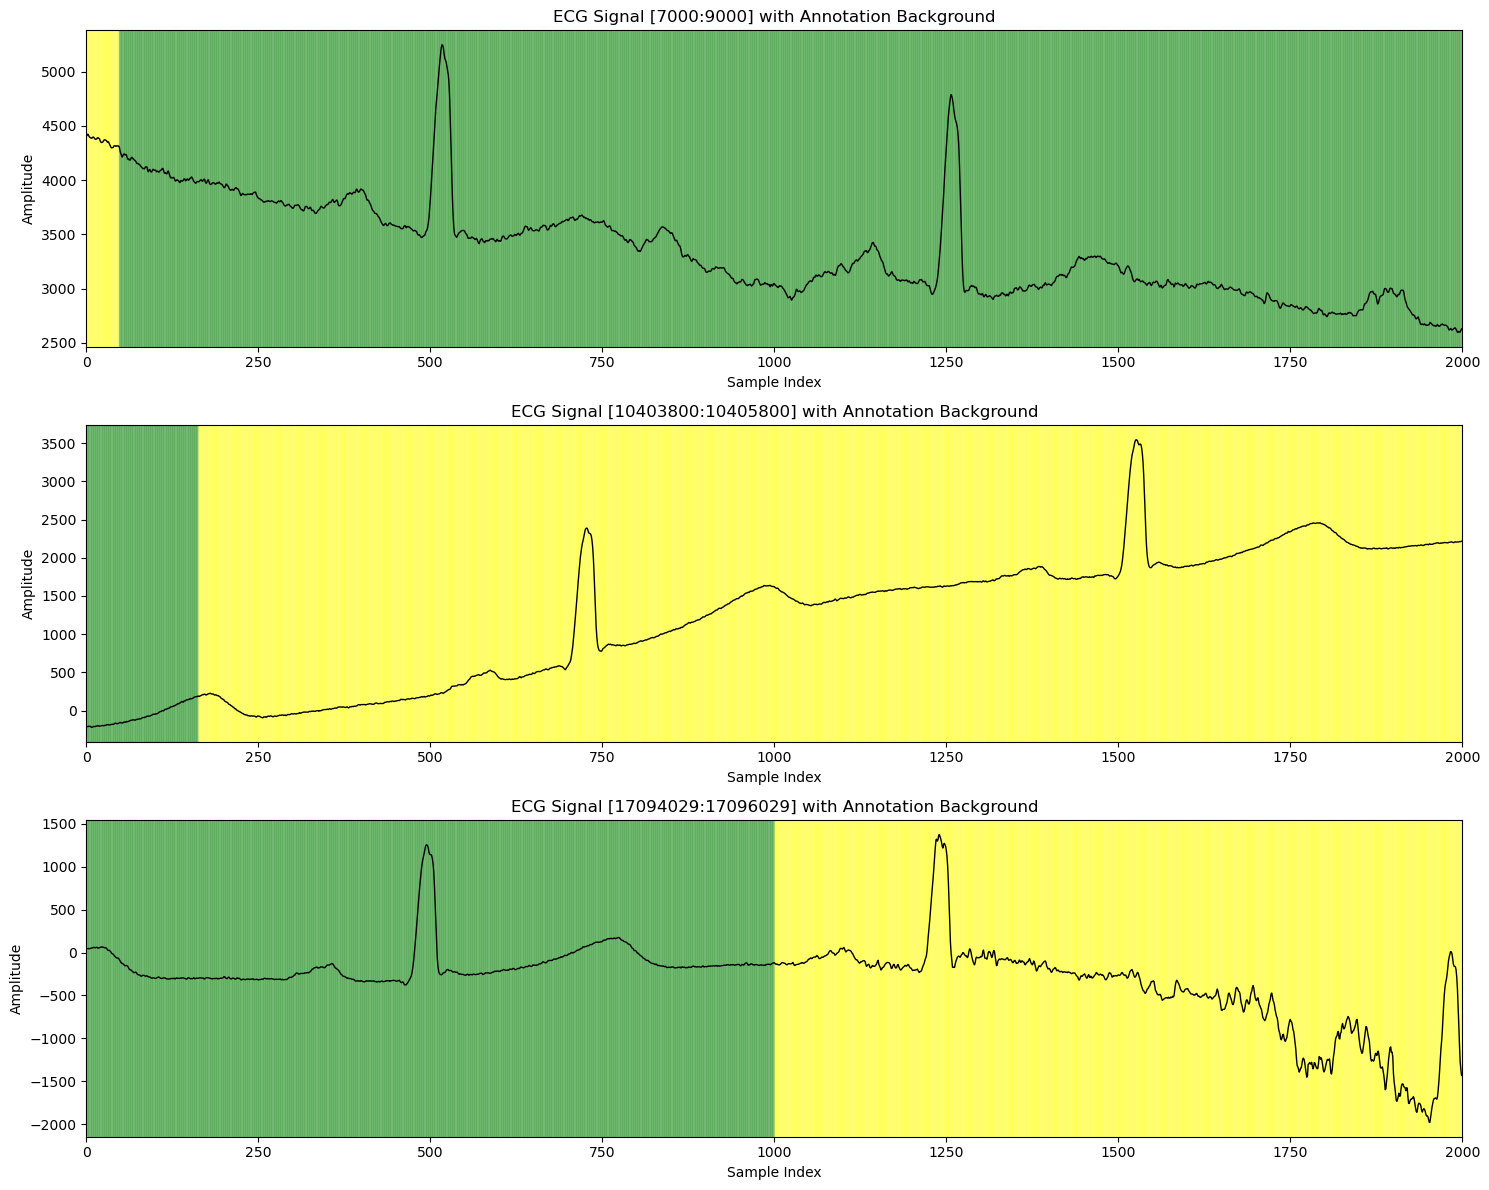

In [8]:
# Define windows to visualize (start, end) tuples
windows = [
    (7000, 9000),  # Example: 2000 samples, adjust as needed
    (10403800, 10405800),
    (17094029, 17096029)
]
colors = {
    1: 'green',   # Good quality
    2: 'yellow',  # Medium quality
    3: 'red'      # Poor quality
}

fig, axes = plt.subplots(len(windows), 1, figsize=(15, 4 * len(windows)), sharex=False)

for idx, (start, end) in enumerate(windows):
    sig = record.p_signal[start:end, 0] if record.p_signal is not None else record.d_signal[start:end, 0]
    ann_window = ann[start:end]
    ax = axes[idx] if len(windows) > 1 else axes

    ax.plot(sig, color='black', linewidth=1)
    for i in range(len(ann_window)):
        ax.axvspan(i, i+1, color=colors.get(ann_window[i], 'gray'), alpha=0.2)
    ax.set_title(f"ECG Signal [{start}:{end}] with Annotation Background")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(0, len(sig))

plt.tight_layout()
plt.show()


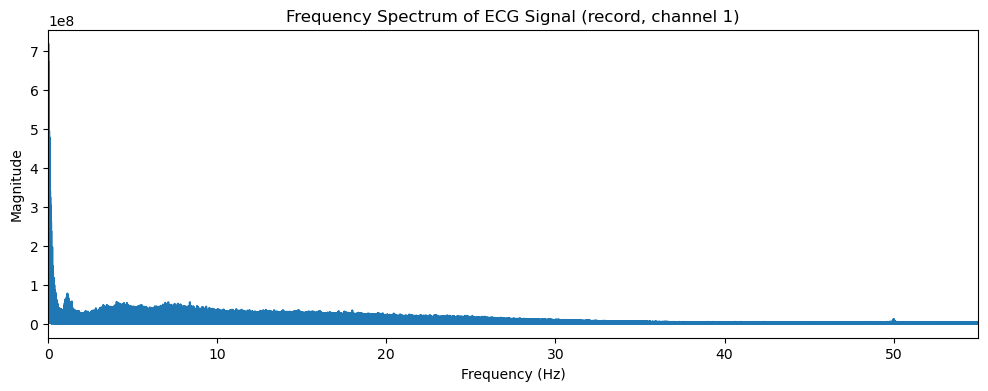

In [7]:
import matplotlib.pyplot as plt

# Frequency analysis using FFT on the signal in 'record'
raw_signal = record.p_signal if record.p_signal is not None else record.d_signal.astype(float)
fs = float(record.fs)
N = raw_signal.shape[0]

# If multi-channel, select first channel for example
sig1 = raw_signal[:, 0] if raw_signal.ndim > 1 else raw_signal

fft_raw = np.fft.fft(sig1)
freqs = np.fft.fftfreq(N, d=1/fs)
plt.figure(figsize=(12, 4))
plt.plot(freqs[:N//2], np.abs(fft_raw)[:N//2])
plt.title("Frequency Spectrum of ECG Signal (record, channel 1)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 55)
plt.show()

In [8]:
b, a = signal.butter(5, 0.5, btype='highpass', fs=fs)
filtered_signal = signal.filtfilt(b, a, raw_signal[:, 0] if raw_signal.ndim > 1 else raw_signal)

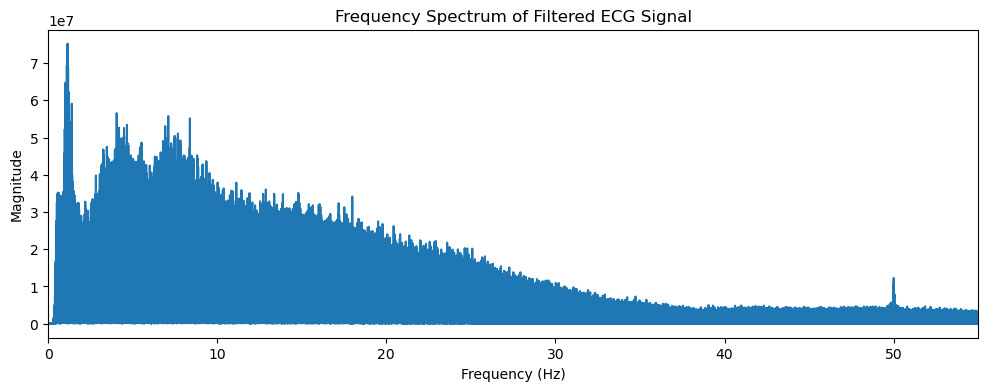

In [9]:
fft_filtered = np.fft.fft(filtered_signal)
freqs_filtered = np.fft.fftfreq(len(filtered_signal), d=1/fs)

plt.figure(figsize=(12, 4))
plt.plot(freqs_filtered[:len(filtered_signal)//2], np.abs(fft_filtered)[:len(filtered_signal)//2])
plt.title("Frequency Spectrum of Filtered ECG Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 55)
plt.show()

In [46]:


# Setup segments for futhere analysis
segments = []
for i in range(len(starts)):
    if pd.isna(starts[i]) or pd.isna(ends[i]) or pd.isna(ann[i]):
        continue
    segments.append((starts[i], ends[i]))
    # print(i)

print(f"Total segments: {len(segments)}")

# # Process each segment with ecg_quality
# quality_results = []
# for seg_start, seg_end, seg_val in segments:
#     # # Limit segment length for practical computation (e.g., max 10000 samples)
#     # if seg_end - seg_start > 10000:
#     #     seg_end = seg_start + 10000
#     segment_signal = raw_signal[seg_start:seg_end, 0] if raw_signal.ndim > 1 else raw_signal[seg_start:seg_end]
#     quality = nk.ecg_quality(segment_signal, sampling_rate=fs, method='averageQRS')
#     quality_results.append({'start': seg_start, 'end': seg_end, 'ann_val': seg_val, 'quality': quality})

Total segments: 763


In [11]:
# print(segments[0][1])



# for seg in segments:
#     nk.ecg_quality(raw_signal[seg[0]:seg[1], 0] if raw_signal.ndim > 1 else raw_signal[seg[0]:seg[1]], sampling_rate=fs, method='averageQRS')

In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd

def sqi_averageQRS(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method="neurokit")
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    q = nk.ecg_quality(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs, method="averageQRS")
    return q  # pr. beat; aggreger i vinduer

def sqi_zhao2018(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    labels = nk.ecg_quality(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs, method="zhao2018")
    # map {"Unacceptable":0, "Barely acceptable":1, "Excellent":2} eller til 0–1
    return labels

def sqi_hrv_rmssd(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = info["ECG_R_Peaks"]
    rr = np.diff(rpeaks) / fs  # sek
    # evt. korriger "uregelmæssige" RR her (tidsvar. tærskler) som i artiklen
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))
    # implementér artiklens tærskel-logik: tælle "abnorme" RR og returnér SQI i [0,1]
    # ... din logik her ...
    return sqi_value

def sqi_morph_corr(ecg, fs, qrs_len=0.12):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    epochs = nk.ecg_segment(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs)
    waves = [np.asarray(epochs[k]["Signal"].values) for k in epochs]  # eller brug epochs_to_df
    # z-score hvert QRS, beregn korrelation mellem konsekutive, tag gennemsnit
    corr = []
    for i in range(len(waves)-1):
        a = (waves[i] - np.mean(waves[i])) / (np.std(waves[i]) + 1e-8)
        b = (waves[i+1] - np.mean(waves[i+1])) / (np.std(waves[i+1]) + 1e-8)
        corr.append(np.corrcoef(a, b)[0,1])
    return float(np.nanmean(corr))

def classify_sqi(sqi_mean):
    if sqi_mean < 0.33:
        return "Unacceptable"
    elif sqi_mean < 0.66:
        return "Barely acceptable"
    else:
        return "Excellent"


In [13]:
# res = sqi_averageQRS(raw_signal[0:10000000],1000)

In [14]:
# print(max(res))
# print(min(res))
# print(len(res))
# print(res[7000:7100])

In [15]:
res = sqi_averageQRS(raw_signal,1000)

In [16]:
result_mean = []
result_median = []

for seg in segments:
    # print(seg[0]-1, seg[1]-1)
    
    res_mean = np.mean(res[seg[0]-1:seg[1]-1])
    result_mean.append(res_mean)
    res_median = np.median(res[seg[0]-1:seg[1]-1])
    result_median.append(res_median)

# Classify based on mean SQI
classified_mean = [classify_sqi(sqi) for sqi in result_mean]
# Classify based on median SQI
classified_median = [classify_sqi(sqi) for sqi in result_median]



In [17]:
# print(len(labels))
# print(len(labels_pred))

In [18]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Prepare DataFrame for evaluation
# df = pd.DataFrame({
#     "label_true": [classify_sqi(val) for val in labels.dropna()],
#     "sqi_mean": result_mean[:len(labels.dropna())]
# })
# df["label_pred"] = df["sqi_mean"].apply(classify_sqi)

# cm = confusion_matrix(df["label_true"], df["label_pred"], labels=["Unacceptable", "Barely acceptable", "Excellent"])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unacceptable", "Barely acceptable", "Excellent"])
# disp.plot(cmap="Blues")
# plt.show()

# print(classification_report(df["label_true"], df["label_pred"]))


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- 1) Kør én gang på HELE signalet ---
ecg_clean = nk.ecg_clean(raw_signal, sampling_rate=fs, method="neurokit")

In [20]:
_, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)

In [ ]:
rpeaks_idx = info["ECG_R_Peaks"]            # beat-indeks i SAMPLES

In [ ]:
# Average SQI
q_beats = nk.ecg_quality(ecg_clean, rpeaks=rpeaks_idx, sampling_rate=fs, method="averageQRS")
# q_beats har samme længde som rpeaks_idx

In [69]:
# SQI Fussy
q_beats_fussy = nk.ecg_quality(ecg_clean[segments[2][0]:segments[2][1]], rpeaks=rpeaks_idx, sampling_rate=fs, method="zhao2018")

In [85]:
counter = 0
q_beats_test1 = []
q_beats_fussy_test1 = []
for seg in segments:
    if seg[1] - seg[0] < 4000:
        q_beats1 = 0
        q_beats_test1.append(np.mean(q_beats1))
        q_beats_fussy1 = "Unacceptable"
        q_beats_fussy_test1.append(q_beats_fussy1)
        counter += 1
        continue
    q_beats1 = nk.ecg_quality(ecg_clean[seg[0]:seg[1], 0] if ecg_clean.ndim > 1 else ecg_clean[seg[0]:seg[1]], sampling_rate=fs, method='averageQRS')
    # print(q_beats1)
    # print(np.mean(q_beats1))
    q_beats_test1.append(np.mean(q_beats1))
    q_beats_fussy1 = nk.ecg_quality(ecg_clean[seg[0]:seg[1], 0] if ecg_clean.ndim > 1 else ecg_clean[seg[0]:seg[1]], sampling_rate=fs, method='zhao2018')
    q_beats_fussy_test1.append(q_beats_fussy1)

print("How many segments skipped due to length < 4000:", counter)



How many segments skipped due to length < 4000: 179


In [66]:
print(segments[0])

(1, 7047)


In [70]:
# Check and validation of parameters
print(len(segments))
print(len(labels))
print(rpeaks_idx.shape)
print(rpeaks_idx[0])

print(segments)
print(q_beats.shape)
print(q_beats_fussy)

763
763
(117206,)
310
[(1, 7047), (7048, 17209), (17210, 28694), (28695, 32653), (32654, 112474), (112475, 174872), (174873, 192330), (192331, 1163574), (1163575, 1165034), (1165035, 2197584), (2197585, 2322254), (2322255, 2331166), (2331167, 2333950), (2333951, 2353306), (2353307, 2582882), (2582883, 2778473), (2778474, 2789032), (2789033, 6493775), (6493776, 6494615), (6494616, 6504788), (6504789, 6528944), (6528945, 8103188), (8103189, 8183677), (8183678, 8207266), (8207267, 8269766), (8269767, 8285982), (8285983, 8679655), (8679656, 8736748), (8736749, 8746245), (8746246, 9369503), (9369504, 9796000), (9796001, 10032664), (10032665, 10033565), (10033566, 10296954), (10296955, 10335664), (10335665, 10403962), (10403963, 10542981), (10542982, 11468257), (11468258, 11477831), (11477832, 11644085), (11644086, 11656399), (11656400, 12844392), (12844393, 12854198), (12854199, 13742716), (13742717, 13760626), (13760627, 15836454), (15836455, 15869858), (15869859, 15993438), (15993439, 160

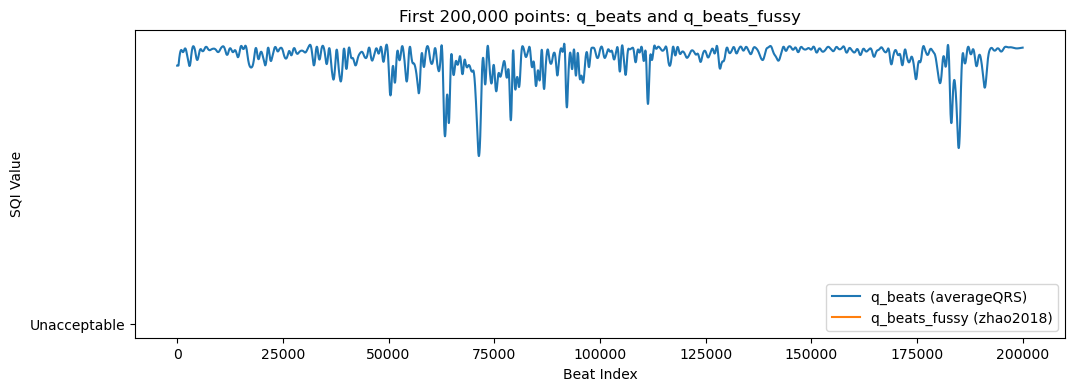

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(q_beats[:200000])
plt.title("First 2000 points in q_beats")
plt.xlabel("Beat Index")
plt.ylabel("SQI (averageQRS)")
plt.show()

In [23]:
# Virker kun på udsnit af signalet. Eks relevant i telemedicin-konteksten?
# signals, info = nk.ecg_process(sig1, sampling_rate=1000)

# nk.ecg_plot(signals, info)

In [ ]:
# print(len(labels))
# print(len(labels_pred))

# print(labels[len(labels)-1])
# print(labels_pred[len(labels_pred)-1])

# print(len(segments))

763
763
2
3
763


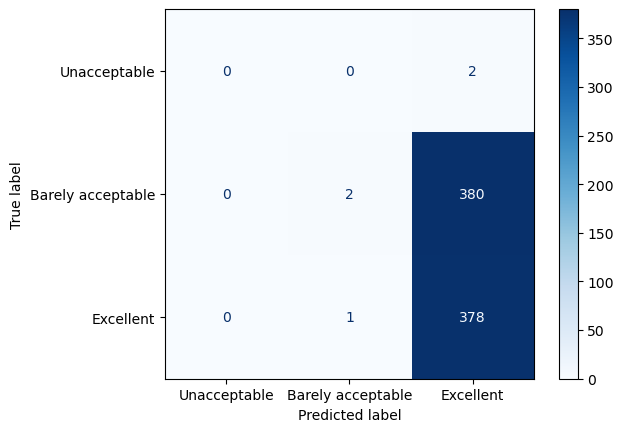

In [81]:
# Get predictions for each segment
labels_pred = []
for seg in segments:
    # Find beats within the segment
    beats_in_segment = (rpeaks_idx >= seg[0]) & (rpeaks_idx <= seg[1])
    seg_q_beats = q_beats[rpeaks_idx[beats_in_segment]]
    if len(seg_q_beats) == 0:
        # No beats in segment, handle as needed (e.g., assign lowest quality)
        labels_pred.append(3)
        continue

    seg_sqi_mean = np.mean(seg_q_beats)
    # seg_sqi_mean = np.min(seg_q_beats)
    # seg_sqi_mean = np.median(seg_q_beats)


    if seg_sqi_mean < 0.5:
        labels_pred.append(3)  # Unacceptable
    elif seg_sqi_mean < 0.8:
        labels_pred.append(2)  # Barely acceptable
    else:
        labels_pred.append(1)  # Excellent

# --- 2) Evaluer resultatet ---
# Prepare DataFrame for evaluation
df = pd.DataFrame({
    "label_true": labels.dropna().astype(int).values,
    "label_pred": labels_pred
})
df["label_true_str"] = df["label_true"].map({1: "Excellent", 2: "Barely acceptable", 3: "Unacceptable"})
df["label_pred_str"] = df["label_pred"].map({1: "Excellent", 2: "Barely acceptable", 3: "Unacceptable"})
cm = confusion_matrix(df["label_true_str"], df["label_pred_str"], labels=["Unacceptable", "Barely acceptable", "Excellent"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unacceptable", "Barely acceptable", "Excellent"])
disp.plot(cmap="Blues")
plt.show()



In [92]:
print(labels[1])
print(labels_true_str[1])
print(labels_true_str_fussy)

1
Excellent
['Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent',

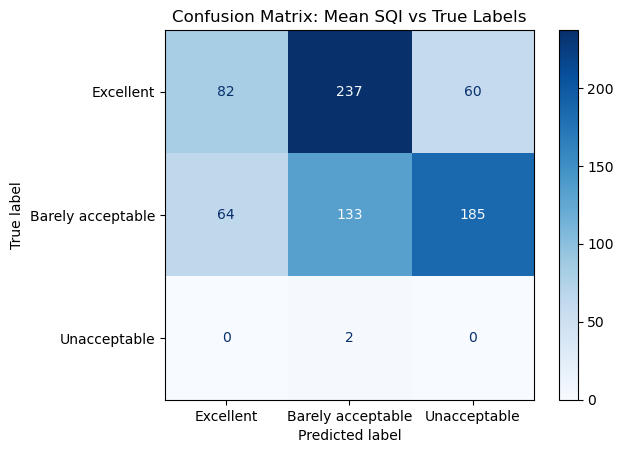

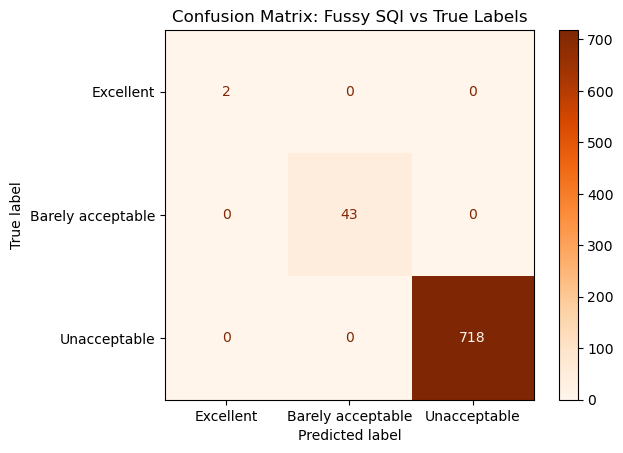

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prepare predicted labels for q_beats_test1 (mean SQI) and q_beats_fussy_test1 (fussy SQI)
def classify_sqi_numeric(sqi_mean):
    if sqi_mean < 0.5:
        return "Unacceptable"
    elif sqi_mean < 0.8:
        return "Barely acceptable"
    else:
        return "Excellent"

def map_labels_to_strings(label_val):
    if label_val == 3:
        return "Unacceptable"
    elif label_val == 2:
        return "Barely acceptable"
    elif label_val == 1:
        return "Excellent"
    else:
        return "Unknown"

# For q_beats_test1 (mean SQI per segment)
labels_pred_mean = [classify_sqi_numeric(val) for val in q_beats_test1]

# For q_beats_fussy_test1 (already string labels)
labels_pred_fussy = q_beats_fussy_test1

# True labels (as string)
labels_true_str = [map_labels_to_strings(val) for val in labels]

import matplotlib.pyplot as plt

# Confusion matrix for mean SQI
cm_mean = confusion_matrix(labels_true_str, labels_pred_mean, labels=CLASSES)
disp_mean = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=CLASSES)
disp_mean.plot(cmap="Blues")
plt.title("Confusion Matrix: Mean SQI vs True Labels")
plt.show()

# Confusion matrix for fussy SQI
# labels_true_str_fussy = [classify_sqi(val) for val in labels[:len(labels_pred_fussy)]]
cm_fussy = confusion_matrix(labels_pred_fussy, labels_pred_fussy, labels=CLASSES)
disp_fussy = ConfusionMatrixDisplay(confusion_matrix=cm_fussy, display_labels=CLASSES)
disp_fussy.plot(cmap="Oranges")
plt.title("Confusion Matrix: Fussy SQI vs True Labels")
plt.show()

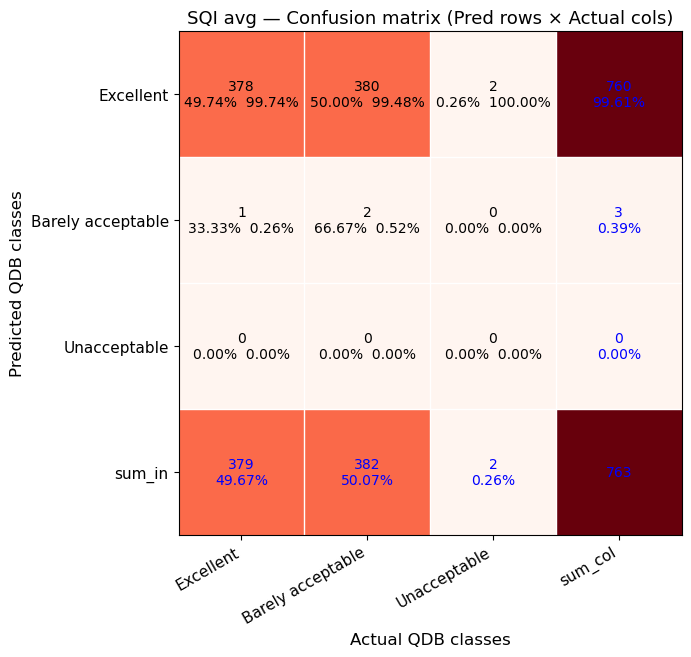

                   precision    recall  f1-score   support

        Excellent       0.50      1.00      0.66       379
Barely acceptable       0.67      0.01      0.01       382
     Unacceptable       0.00      0.00      0.00         2

         accuracy                           0.50       763
        macro avg       0.39      0.33      0.22       763
     weighted avg       0.58      0.50      0.33       763



In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 0) Ind: y_true, y_pred
#    Brug dine eksisterende arrays/serier her:
#    - df["label_true_str"], df["label_pred_str"] i strenge
#    ELLER map dine 1/2/3 -> strenge nedenfor.
# =========================

# >>> Skift disse to til dine egne variabler, hvis de allerede er strenge:
y_true_in = df["label_true"]  # kan være 1/2/3 eller tekst
y_pred_in = df["label_pred"]

# Kanoniser labels til samme 3 strenge
CLASSES = ["Excellent", "Barely acceptable", "Unacceptable"]

def canon_label(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip().lower()
    m = {
        "0":"unacceptable", "1":"barely acceptable", "2":"excellent",
        "1.0":"barely acceptable", "2.0":"excellent",
        "3":"unacceptable", "3.0":"unacceptable",
        "excellent":"excellent", "barely acceptable":"barely acceptable",
        "unacceptable":"unacceptable",
        # danske synonymer (valgfrit)
        "god":"excellent", "middel":"barely acceptable", "dårlig":"unacceptable"
    }
    # Hvis dine sande labels er 1/2/3 med 1=Excellent, 2=Barely, 3=Unacceptable:
    if s in {"1","1.0"}: return "Excellent"
    if s in {"2","2.0"}: return "Barely acceptable"
    if s in {"3","3.0"}: return "Unacceptable"
    # fallback til 0/1/2 mapping
    if s in m: s = m[s]
    # titel-case tilbage
    return {"excellent":"Excellent","barely acceptable":"Barely acceptable","unacceptable":"Unacceptable"}.get(s, None)

y_true = pd.Series([canon_label(v) for v in y_true_in]).dropna()
y_pred = pd.Series([canon_label(v) for v in y_pred_in]).iloc[:len(y_true)]
y_true = y_true.iloc[:len(y_pred)]

# =========================
# 1) Confusion matrix (sklearn er True x Pred; vi transponerer til Pred x True)
# =========================
cm_tp = confusion_matrix(y_true, y_pred, labels=CLASSES)   # rows=true, cols=pred
cm = cm_tp.T                                               # rows=pred, cols=true  ✅ som i artiklen

row_sum = cm.sum(axis=1, keepdims=True)
col_sum = cm.sum(axis=0, keepdims=True)
total   = cm.sum()

# undgå division by zero
row_pct = np.divide(cm, row_sum, out=np.zeros_like(cm, dtype=float), where=row_sum!=0)  # pr. RÆKKE (precision-lign.)
col_pct = np.divide(cm, col_sum, out=np.zeros_like(cm, dtype=float), where=col_sum!=0)  # pr. KOLONNE (recall-lign.)

# =========================
# 2) Plot med rand-summer (sum_row / sum_col) og tekst i celler
# =========================
fig, ax = plt.subplots(figsize=(7,7))
# udvidet matrix 4x4 med totals
cm_aug = np.zeros((len(CLASSES)+1, len(CLASSES)+1), dtype=int)
cm_aug[:-1,:-1] = cm
cm_aug[:-1,-1]  = row_sum.ravel()     # sum_in (rækker = predicted)
cm_aug[-1,:-1]  = col_sum.ravel()     # sum_col (kolonner = actual)
cm_aug[-1,-1]   = total

im = ax.imshow(cm_aug, cmap="Reds")

# akse-etiketter (som i artiklen)
row_labels = CLASSES + ["sum_in"]
col_labels = CLASSES + ["sum_col"]
ax.set_yticks(range(len(row_labels))); ax.set_yticklabels(row_labels, fontsize=11)
ax.set_xticks(range(len(col_labels))); ax.set_xticklabels(col_labels, fontsize=11, rotation=30, ha="right")

ax.set_ylabel("Predicted QDB classes", fontsize=12)
ax.set_xlabel("Actual QDB classes", fontsize=12)
ax.set_title("SQI avg — Confusion matrix (Pred rows × Actual cols)", fontsize=13)

# tekst-annoteringer
for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        c = cm[i, j]
        r = row_pct[i, j] * 100.0
        k = col_pct[i, j] * 100.0
        # to linjer: antal + (række%, kolonne%)
        txt = f"{c}\n{r:.2f}%  {k:.2f}%"
        ax.text(j, i, txt, va="center", ha="center", fontsize=10, color="black")

# rand-celler (summer + andele)
for i in range(len(CLASSES)):  # sidste kolonne (sum_in / pr. række)
    rcount = row_sum[i,0]
    rperc  = 100.0 * (rcount / total) if total else 0.0
    ax.text(len(CLASSES), i, f"{rcount}\n{rperc:.2f}%", va="center", ha="center", fontsize=10, color="blue")

for j in range(len(CLASSES)):  # sidste række (sum_col / pr. kolonne)
    ccount = col_sum[0,j]
    cperc  = 100.0 * (ccount / total) if total else 0.0
    ax.text(j, len(CLASSES), f"{ccount}\n{cperc:.2f}%", va="center", ha="center", fontsize=10, color="blue")

# nederste højre (total)
ax.text(len(CLASSES), len(CLASSES), f"{total}", va="center", ha="center", fontsize=10, color="blue")

# gitterlinjer for læsbarhed
ax.set_xlim(-0.5, len(CLASSES)+0.5)
ax.set_ylim(len(CLASSES)+0.5, -0.5)
ax.grid(False)
for x in range(len(CLASSES)):
    ax.axvline(x+0.5, color="white", lw=1)
    ax.axhline(x+0.5, color="white", lw=1)

plt.tight_layout()
plt.show()

# (valgfrit) Klassifikationsrapport — NB: kræver true/pred i samme orden
print(classification_report(y_true, y_pred, labels=CLASSES, zero_division=0))


In [ ]:
# ============================================================
# SQI reference-implementation (Sensors 2023; NeuroKit2)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import neurokit2 as nk
import math

# ---------------------------
# 0) Hjælpefunktioner
# ---------------------------
CLASSES = ["Unacceptable", "Barely acceptable", "Excellent"]  # fast rækkefølge

def canon_label(x):
    """Map 0/1/2/3 eller tekst -> tre kanoniske strenge."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip()
    low = s.lower()
    # typisk QDB-kodning: 1=Excellent, 2=Barely acceptable, 3=Unacceptable
    if s in {"1", "1.0"}: return "Excellent"
    if s in {"2", "2.0"}: return "Barely acceptable"
    if s in {"3", "3.0"}: return "Unacceptable"
    # andre varianter (0/1/2)
    if s in {"0", "0.0"}: return None
    if s in {"2","2.0"}: return "Barely acceptable"
    if s in {"excellent","god"}: return "Excellent"
    if low in {"barely acceptable","middel","medium"}: return "Barely acceptable"
    if low in {"unacceptable","daarlig","dårlig","poor"}: return "Unacceptable"
    return None

def classify_3bins(x, t1, t2, higher_is_better=True):
    """Map et kontinuerligt SQI-tal til tre klasser med to tærskler."""
    if x is None or (isinstance(x, float) and (np.isnan(x) or math.isinf(x))):
        return None
    v = float(x)
    if higher_is_better:
        if v < t1:  return "Unacceptable"
        if v < t2:  return "Barely acceptable"
        return "Excellent"
    else:
        # hvis lavere er bedre (ikke brugt her, men praktisk hvis du ændrer)
        if v > t2:  return "Unacceptable"
        if v > t1:  return "Barely acceptable"
        return "Excellent"

def grid_fit_thresholds(scores, y_true, higher_is_better=True, n=101):
    """Bruteforce to tærskler t1<t2, maksimerer macro-F1 på træningsdata."""
    scores = np.asarray(scores, float)
    y_true = pd.Series(y_true).astype(str)
    a, b = np.nanmin(scores), np.nanmax(scores)
    if not np.isfinite(a) or not np.isfinite(b) or a==b:
        return (0.33, 0.66)
    best, best_pair = -1, (a+(b-a)*0.33, a+(b-a)*0.66)
    grid = np.linspace(a, b, n)
    for i in range(n-2):
        for j in range(i+1, n-1):
            t1, t2 = grid[i], grid[j]
            pred = [classify_3bins(v, t1, t2, higher_is_better) for v in scores]
            df = pd.DataFrame({"t": y_true.values, "p": pred})
            df = df.dropna()
            if df.empty: 
                continue
            cm = confusion_matrix(df["t"], df["p"], labels=CLASSES)
            # macro-F1
            prec = np.divide(np.diag(cm), np.maximum(cm.sum(axis=0), 1))
            rec  = np.divide(np.diag(cm), np.maximum(cm.sum(axis=1), 1))
            f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
            score = np.nanmean(f1)
            if score > best:
                best, best_pair = score, (t1, t2)
    return best_pair

def plot_confusion_pred_rows(y_true, y_pred, title="Confusion (Pred×Actual)"):
    """Plot som i artiklen: rækker = Pred, kolonner = Actual, inkl. summer og %."""
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    cm_tp = confusion_matrix(y_true, y_pred, labels=CLASSES)  # rows=true, cols=pred
    cm = cm_tp.T                                              # rows=pred, cols=true
    row_sum = cm.sum(axis=1, keepdims=True)
    col_sum = cm.sum(axis=0, keepdims=True)
    total   = cm.sum()

    fig, ax = plt.subplots(figsize=(7,7))
    cm_aug = np.zeros((4,4), int)
    cm_aug[:-1,:-1] = cm
    cm_aug[:-1,-1]  = row_sum.ravel()
    cm_aug[-1,:-1]  = col_sum.ravel()
    cm_aug[-1,-1]   = total
    im = ax.imshow(cm_aug, cmap="Reds")
    ax.set_yticks(range(4)); ax.set_xticks(range(4))
    ax.set_yticklabels(CLASSES+["sum_in"]); ax.set_xticklabels(CLASSES+["sum_col"], rotation=30, ha="right")
    ax.set_ylabel("Predicted QDB classes"); ax.set_xlabel("Actual QDB classes"); ax.set_title(title)

    # cell-tekster
    row_pct = np.divide(cm, np.maximum(row_sum,1))
    col_pct = np.divide(cm, np.maximum(col_sum,1))
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f"{cm[i,j]}\n{row_pct[i,j]*100:.1f}%  {col_pct[i,j]*100:.1f}%", ha="center", va="center", fontsize=10)
    for i in range(3):
        ax.text(3, i, f"{row_sum[i,0]}\n{(row_sum[i,0]/max(total,1))*100:.1f}%", ha="center", va="center", color="blue")
    for j in range(3):
        ax.text(j, 3, f"{col_sum[0,j]}\n{(col_sum[0,j]/max(total,1))*100:.1f}%", ha="center", va="center", color="blue")
    ax.text(3,3, f"{total}", ha="center", va="center", color="blue")
    for x in range(3):
        ax.axvline(x+0.5, color="white"); ax.axhline(x+0.5, color="white")
    plt.tight_layout(); plt.show()
    print(classification_report(y_true, y_pred, labels=CLASSES, zero_division=0))

def build_segments_from_csv(csv_path):
    """Læs QDBs consensus kolonner (start, stop, class) -> segments, labels."""
    df = pd.read_csv(csv_path, header=None)
    starts = df.iloc[:, 9].astype(int).values
    stops  = df.iloc[:,10].astype(int).values
    labs   = df.iloc[:,11].values
    segments = [(int(s), int(e)) for s,e in zip(starts, stops)]
    labels   = [canon_label(v) for v in labs]
    return segments, labels

# --- NYT: segmentvis Zhao2018 evaluering ---
def eval_zhao2018_segmentwise(ecg, fs, segments, labels=None, units="samples", min_beats=3):
    import neurokit2 as nk
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = np.asarray(info["ECG_R_Peaks"], dtype=int)

    rows = []
    for i, seg in enumerate(segments):
        # hent segment + true label
        if len(seg) == 3:
            s0, s1, y = seg
            y_true = canon_label(y)
        else:
            s0, s1 = seg
            y_true = canon_label(labels[i]) if labels is not None else None

        if units == "seconds":
            s0, s1 = int(round(s0*fs)), int(round(s1*fs))
        if s1 < s0:
            s0, s1 = s1, s0

        # beats i segment
        m = (rpeaks >= s0) & (rpeaks <= s1)
        n_beats = int(np.sum(m))

        # for korte segmenter -> ukendt
        if n_beats < min_beats:
            y_pred = None
        else:
            # lokaliser signal og rpeaks til segmentet
            ecg_seg = ecg_clean[s0:s1+1]
            rp_local = rpeaks[m] - s0
            try:
                lab = nk.ecg_quality(ecg_seg, rpeaks=rp_local, sampling_rate=fs, method="zhao2018")
            except Exception:
                lab = None
            y_pred = canon_label(lab)

        rows.append({
            "seg_id": i, "start": int(s0), "end": int(s1),
            "n_beats": n_beats, "label_true": y_true, "label_pred": y_pred
        })

    return pd.DataFrame(rows)

# ---------------------------
# 1) SQI’er (per-beat)
# ---------------------------
def sqi_averageQRS(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = info["ECG_R_Peaks"]
    q = nk.ecg_quality(ecg_clean, rpeaks=rpeaks, sampling_rate=fs, method="averageQRS")
    # return per-beat score (højere = bedre), og r-peak indices
    return np.asarray(q, float), np.asarray(rpeaks, int)

def sqi_zhao2018(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = info["ECG_R_Peaks"]
    labels = nk.ecg_quality(ecg_clean, rpeaks=rpeaks, sampling_rate=fs, method="zhao2018")
    # map til samme tre strenge
    mapping = {"Excellent":"Excellent", "Barely acceptable":"Barely acceptable", "Unacceptable":"Unacceptable"}
    labels = [mapping.get(str(x), None) for x in labels]
    return np.array(labels, dtype=object), np.asarray(rpeaks, int)

def sqi_hrv_rmssd(ecg, fs):
    """En simpel HRV-baseret SQI: højere score = bedre (1 - outlier-rate)."""
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = info["ECG_R_Peaks"].astype(int)
    rr = np.diff(r) / fs
    if rr.size < 3:
        return np.array([]), r
    # adaptive outlier flag (IQR)
    q1, q3 = np.percentile(rr, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    bad = (rr < lo) | (rr > hi)
    # beat-aligned score: assign score to the *second* beat in each RR
    score = 1.0 - bad.astype(float)
    # pad to same length as rpeaks
    score = np.r_[np.nan, score]  # first beat has no preceding RR
    return score, r

def sqi_morph_corr_consecutive(ecg, fs, w_pre=0.18, w_post=0.22):
    """Korrelation mellem konsekutive QRS-segmenter (højere = bedre)."""
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = info["ECG_R_Peaks"].astype(int)
    if r.size < 3:
        return np.array([]), r
    pre = int(w_pre*fs); post = int(w_post*fs)
    segs = []
    n = len(ecg_clean)
    for rp in r:
        s = max(0, rp - pre); e = min(n, rp + post)
        w = ecg_clean[s:e]
        # ens længde via padding
        if len(w) < pre+post:
            w = np.pad(w, (0, pre+post-len(w)), mode="edge")
        segs.append((w - np.mean(w)) / (np.std(w) + 1e-8))
    segs = np.vstack(segs)
    corr = np.array([np.corrcoef(segs[i], segs[i+1])[0,1] for i in range(len(segs)-1)])
    score = np.r_[np.nan, corr]  # align til beats
    return score, r

def sqi_hrv_local(rr_ms, win=7, tol=0.12):
    """
    rr_ms: RR i millisekunder.
    win: længde af glidende median (ulige tal).
    tol: relativ tolerance (0.12 ~ 12%) omkring lokal median.
    Returnerer per-beat score i [0,1]: 1=normal RR, 0=abnorm.
    """
    rr = np.asarray(rr_ms, float)
    if rr.size < 3:
        return np.array([])
    # glidende median
    k = win // 2
    med = np.array([np.median(rr[max(0,i-k):min(len(rr),i+k+1)]) for i in range(len(rr))])
    bad = np.abs(rr - med) > (tol * med)
    # beat-alignment: score for 2..N slag (første RR hører til beat #2)
    score = 1.0 - bad.astype(float)
    score = np.r_[np.nan, score]  # align til beats
    return score

def sqi_hrv_segmentwise(ecg, fs, tol=0.12, win=7):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = info["ECG_R_Peaks"].astype(int)
    if r.size < 3:
        return np.array([]), r
    rr_ms = 1000.0 * np.diff(r) / fs
    score = sqi_hrv_local(rr_ms, win=win, tol=tol)  # højere = bedre
    return score, r


# ---------------------------
# 2) Aggregér per segment
# ---------------------------
def _ensure_perbeat(values, rpeaks_idx):
    """Sørg for at 'values' er per-beat (samme længde som rpeaks_idx).
       Hvis 'values' er per-sample, konverter til per-beat via rpeaks_idx."""
    arr = np.asarray(values)
    rpeaks_idx = np.asarray(rpeaks_idx, dtype=int)
    if arr.shape[0] == rpeaks_idx.shape[0]:
        return arr  # allerede per-beat
    # per-sample? så kan vi tage værdier ved R-peak positionerne
    if int(np.max(rpeaks_idx)) < arr.shape[0]:
        return arr[rpeaks_idx]
    raise ValueError(
        f"Uforenelige længder: len(values)={arr.shape[0]}, len(rpeaks_idx)={rpeaks_idx.shape[0]} "
        "(values er hverken per-beat eller per-sample i samme signal)."
    )

def aggregate_by_segments(per_beat_values, rpeaks_idx, segments, labels=None, fs=None,
                          units="samples", min_beats=3, agg="median"):
    # --- NYT: sikr per-beat format ---
    per_beat_values = _ensure_perbeat(per_beat_values, rpeaks_idx)
    rpeaks_idx = np.asarray(rpeaks_idx, dtype=int)

    if (labels is not None) and (len(labels) != len(segments)):
        raise ValueError("labels og segments skal have samme længde")

    rows = []
    for i, seg in enumerate(segments):
        if len(seg) == 3:
            s0, s1, y = seg
            y_true = canon_label(y)
        else:
            s0, s1 = seg
            y_true = canon_label(labels[i]) if labels is not None else None

        if units == "seconds":
            if fs is None:
                raise ValueError("fs kræves når units='seconds'")
            s0, s1 = int(round(s0*fs)), int(round(s1*fs))
        if s1 < s0: s0, s1 = s1, s0

        # maskér beats inde i segmentet (maskens længde = antal beats)
        m = (rpeaks_idx >= s0) & (rpeaks_idx <= s1)

        # >>> VIGTIGT: brug masken direkte på per-beat vektoren
        vals = per_beat_values[m]
        vals = vals[np.isfinite(vals)]
        n = vals.size

        if n >= min_beats:
            seg_q = float(np.nanmedian(vals) if agg == "median" else np.nanmean(vals))
        else:
            seg_q = np.nan

        rows.append({
            "seg_id": i,
            "start": int(s0), "end": int(s1),
            "n_beats": int(n),
            "label_true": y_true,
            "sqi_mean": seg_q
        })
    return pd.DataFrame(rows)


# ---------------------------
# 3) End-to-end evaluering
# ---------------------------
def run_sqi_eval_all(ecg, fs, segments, labels, units="samples",
                     fit_thresholds=True, min_beats=3, agg="median"):
    out = {}

    # --- averageQRS ---
    avg_scores, r_idx = sqi_averageQRS(ecg, fs)
    df_avg = aggregate_by_segments(avg_scores, r_idx, segments, labels, fs, units, min_beats, agg)
    y_true = df_avg["label_true"].dropna()
    y_true = y_true.iloc[df_avg["sqi_mean"].notna().values]
    avg_vals = df_avg["sqi_mean"].dropna().values
    if fit_thresholds:
        t1, t2 = grid_fit_thresholds(avg_vals, y_true.values, higher_is_better=True)
    else:
        t1, t2 = 0.33, 0.66
    y_pred = [classify_3bins(v, t1, t2, True) for v in df_avg["sqi_mean"]]
    df_avg["label_pred"] = y_pred
    print(f"[averageQRS] thresholds: t1={t1:.3f}, t2={t2:.3f}  (higher is better)")
    eval_df = df_avg[df_avg["label_pred"].notna() & df_avg["label_true"].notna()]
    plot_confusion_pred_rows(eval_df["label_true"], eval_df["label_pred"],
                             title="SQI avg (averageQRS) — Pred × Actual")
    out["averageQRS"] = df_avg

    # --- zhao2018 (segmentvist; returnerer direkte klasser pr. segment) ---
    df_zh = eval_zhao2018_segmentwise(ecg, fs, segments, labels, units=units, min_beats=min_beats)
    eval_df = df_zh[df_zh["label_pred"].notna() & df_zh["label_true"].notna()]
    plot_confusion_pred_rows(eval_df["label_true"], eval_df["label_pred"],
                            title="SQI zhao2018 (segment-wise) — Pred × Actual")
    out["zhao2018"] = df_zh

    # --- HRV (RMSSD/outlier-rate proxy; higher=better) ---
    hrv_score, r_idx = sqi_hrv_rmssd(ecg, fs)
    df_hrv = aggregate_by_segments(hrv_score, r_idx, segments, labels, fs, units, min_beats, agg)
    # fit egne tærskler på hrv-score også (de kan afvige)
    vals = df_hrv["sqi_mean"].dropna().values
    ytr  = df_hrv["label_true"][df_hrv["sqi_mean"].notna()]
    if vals.size >= 20:
        ht1, ht2 = grid_fit_thresholds(vals, ytr.values, higher_is_better=True)
    else:
        ht1, ht2 = t1, t2
    df_hrv["label_pred"] = [classify_3bins(v, ht1, ht2, True) for v in df_hrv["sqi_mean"]]
    eval_df = df_hrv[df_hrv["label_pred"].notna() & df_hrv["label_true"].notna()]
    print(f"[HRV] thresholds: t1={ht1:.3f}, t2={ht2:.3f}")
    plot_confusion_pred_rows(eval_df["label_true"], eval_df["label_pred"],
                             title="SQI HRV — Pred × Actual")
    out["hrv"] = df_hrv

    # --- Morfologisk korrelation (konsekutive QRS’er; higher=better) ---
    morph, r_idx = sqi_morph_corr_consecutive(ecg, fs)
    df_m = aggregate_by_segments(morph, r_idx, segments, labels, fs, units, min_beats, agg)
    vals = df_m["sqi_mean"].dropna().values
    ytr  = df_m["label_true"][df_m["sqi_mean"].notna()]
    if vals.size >= 20:
        mt1, mt2 = grid_fit_thresholds(vals, ytr.values, higher_is_better=True)
    else:
        mt1, mt2 = t1, t2
    df_m["label_pred"] = [classify_3bins(v, mt1, mt2, True) for v in df_m["sqi_mean"]]
    eval_df = df_m[df_m["label_pred"].notna() & df_m["label_true"].notna()]
    print(f"[MorphCorr] thresholds: t1={mt1:.3f}, t2={mt2:.3f}")
    plot_confusion_pred_rows(eval_df["label_true"], eval_df["label_pred"],
                             title="SQI Morph Corr — Pred × Actual")
    out["morph_corr"] = df_m

    return out


In [30]:
print("Zhao rows:", len(df_zh))
print("GT:", df_zh["label_true"].value_counts(dropna=False))
print("Pred:", df_zh["label_pred"].value_counts(dropna=False))


NameError: name 'df_zh' is not defined

In [27]:
# load a record using the 'rdrecord' function
record = wfdb.rdrecord(ecg_path)

raw_signal = record.p_signal if record.p_signal is not None else record.d_signal.astype(float)
fs = float(record.fs)

ann, starts, ends, labels, segments = ann_reader(base_path + r"_ANN.csv")



C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encounte

[averageQRS] thresholds: t1=0.949, t2=0.990  (higher is better)


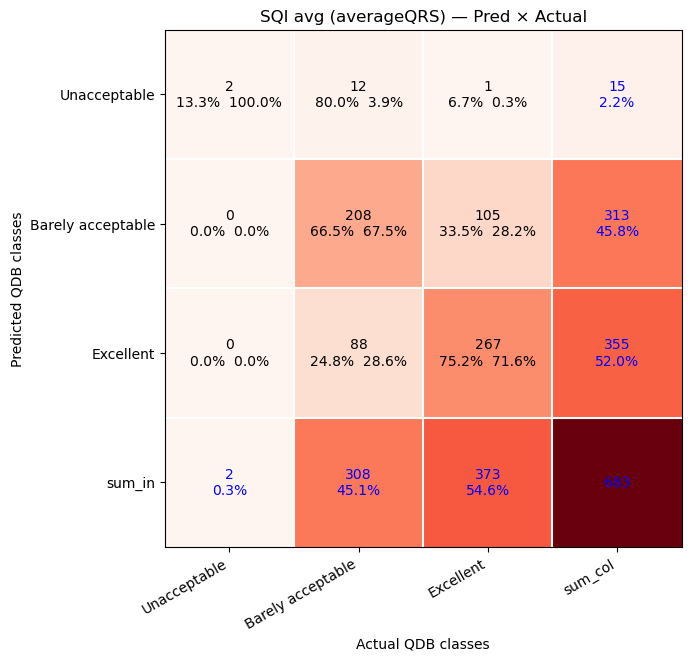

                   precision    recall  f1-score   support

     Unacceptable       0.13      1.00      0.24         2
Barely acceptable       0.66      0.68      0.67       308
        Excellent       0.75      0.72      0.73       373

         accuracy                           0.70       683
        macro avg       0.52      0.80      0.55       683
     weighted avg       0.71      0.70      0.70       683



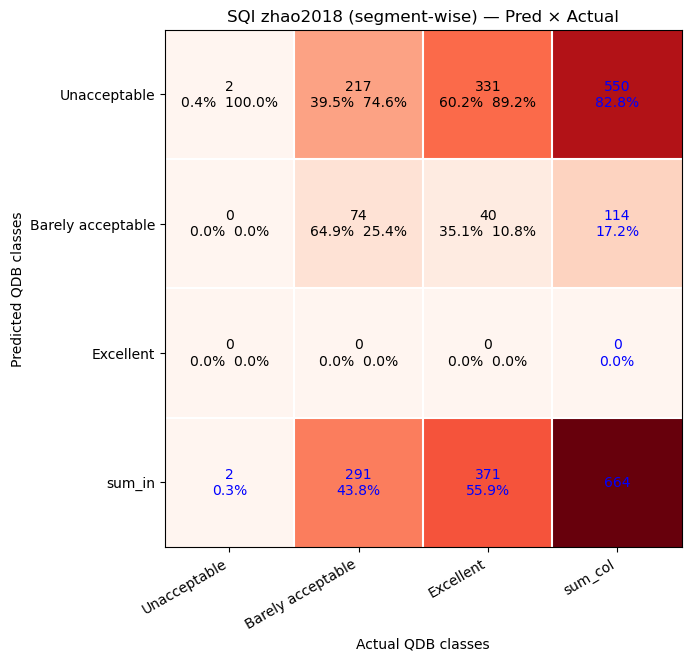

                   precision    recall  f1-score   support

     Unacceptable       0.00      1.00      0.01         2
Barely acceptable       0.65      0.25      0.37       291
        Excellent       0.00      0.00      0.00       371

         accuracy                           0.11       664
        macro avg       0.22      0.42      0.12       664
     weighted avg       0.28      0.11      0.16       664

[HRV] thresholds: t1=0.330, t2=0.660


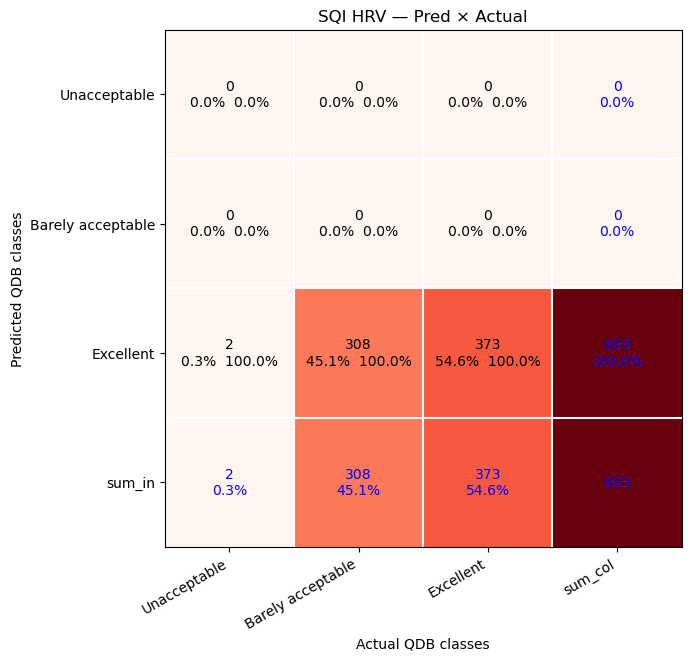

                   precision    recall  f1-score   support

     Unacceptable       0.00      0.00      0.00         2
Barely acceptable       0.00      0.00      0.00       308
        Excellent       0.55      1.00      0.71       373

         accuracy                           0.55       683
        macro avg       0.18      0.33      0.24       683
     weighted avg       0.30      0.55      0.39       683



C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\1320691906.py:70: RuntimeWarning: invalid value encounte

[MorphCorr] thresholds: t1=0.343, t2=0.993


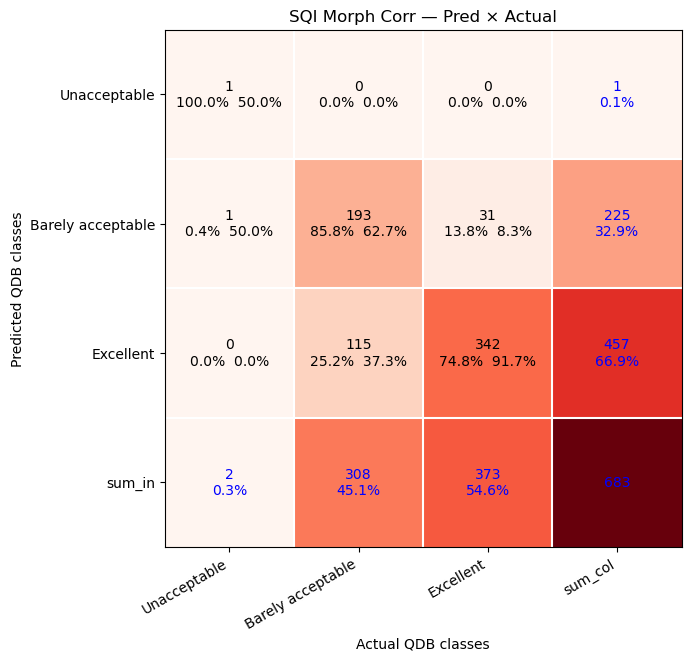

                   precision    recall  f1-score   support

     Unacceptable       1.00      0.50      0.67         2
Barely acceptable       0.86      0.63      0.72       308
        Excellent       0.75      0.92      0.82       373

         accuracy                           0.78       683
        macro avg       0.87      0.68      0.74       683
     weighted avg       0.80      0.78      0.78       683



In [32]:
# 1) Du har allerede ecg, fs, segments, labels (i samples). Hvis segmenter er i sekunder: units="seconds".
results = run_sqi_eval_all(
    ecg=raw_signal, 
    fs=1000, 
    segments=segments, 
    labels=labels,          # fx din 'vals' eller lign.
    units="samples",        # eller "seconds"
    fit_thresholds=True,    # grid-searcher t1,t2 på dine data (som i artiklens harmonisering)
    min_beats=3,
    agg="median"
)


In [33]:
print("GT fordeling:", pd.Series(labels).value_counts())
print("Segmentlængde (s):", np.median([(e-s)/fs for s,e in segments]))


GT fordeling: 11
2    382
1    379
3      2
Name: count, dtype: Int64
Segmentlængde (s): 15.791


In [34]:
# ==========================================
# SQI end-to-end (Sensors 2023 style)
# ==========================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import neurokit2 as nk

# ---------- Konstanter ----------
CLASSES = ["Unacceptable", "Barely acceptable", "Excellent"]  # fast rækkefølge i CM

# ---------- Hjælp: label-mapping ----------
def canon_label(x):
    """Map 1/2/3 eller tekst -> tre kanoniske strenge. Returnerer None ved ukendt."""
    if x is None or (isinstance(x, float) and np.isnan(x)): return None
    s = str(x).strip()
    sl = s.lower()
    # QDB standard: 1=Excellent, 2=Barely acceptable, 3=Unacceptable
    if s in {"1","1.0"}: return "Excellent"
    if s in {"2","2.0"}: return "Barely acceptable"
    if s in {"3","3.0"}: return "Unacceptable"
    # Tekst-varianter (dansk/eng.)
    if sl in {"excellent","god"}: return "Excellent"
    if sl in {"barely acceptable","middel","medium"}: return "Barely acceptable"
    if sl in {"unacceptable","dårlig","daarlig","poor"}: return "Unacceptable"
    return None

def classify_3bins(x, t1, t2, higher_is_better=True):
    """Kontinuerlig SQI -> 3 klasser via to tærskler."""
    if x is None or (isinstance(x, float) and (np.isnan(x) or math.isinf(x))): return None
    v = float(x)
    if higher_is_better:
        if v < t1: return "Unacceptable"
        if v < t2: return "Barely acceptable"
        return "Excellent"
    else:
        if v > t2: return "Unacceptable"
        if v > t1: return "Barely acceptable"
        return "Excellent"

def grid_fit_thresholds(scores, y_true, higher_is_better=True, n=61):
    """Brute force t1<t2 for macro-F1 (på træningsdata). Returnerer (t1,t2)."""
    scores = np.asarray(scores, float)
    y_true = pd.Series(y_true)
    a, b = np.nanmin(scores), np.nanmax(scores)
    if not np.isfinite(a) or not np.isfinite(b) or a == b:
        return (0.33, 0.66)
    best, best_pair = -1.0, (a+(b-a)*0.33, a+(b-a)*0.66)
    grid = np.linspace(a, b, n)
    for i in range(n-2):
        for j in range(i+1, n-1):
            t1, t2 = grid[i], grid[j]
            pred = [classify_3bins(v, t1, t2, higher_is_better) for v in scores]
            df = pd.DataFrame({"t": y_true.values, "p": pred}).dropna()
            if df.empty: continue
            cm_tp = confusion_matrix(df["t"], df["p"], labels=CLASSES)     # rows=true, cols=pred
            cm = cm_tp.T                                                   # rows=pred, cols=true
            prec = np.divide(np.diag(cm), np.maximum(cm.sum(axis=1), 1))
            rec  = np.divide(np.diag(cm), np.maximum(cm.sum(axis=0), 1))
            f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
            score = float(np.nanmean(f1))
            if score > best:
                best, best_pair = score, (t1, t2)
    return best_pair

# ---------- Hjælp: CM som i artiklen ----------
def plot_confusion_pred_rows(y_true, y_pred, title="Confusion (Pred×Actual)"):
    y_true = pd.Series(y_true); y_pred = pd.Series(y_pred)
    cm_tp = confusion_matrix(y_true, y_pred, labels=CLASSES)  # rows=true, cols=pred
    cm = cm_tp.T                                              # rows=pred, cols=true
    row_sum = cm.sum(axis=1, keepdims=True)
    col_sum = cm.sum(axis=0, keepdims=True)
    total   = cm.sum()

    fig, ax = plt.subplots(figsize=(7,7))
    cm_aug = np.zeros((4,4), int)
    cm_aug[:-1,:-1] = cm
    cm_aug[:-1,-1]  = row_sum.ravel()
    cm_aug[-1,:-1]  = col_sum.ravel()
    cm_aug[-1,-1]   = total
    ax.imshow(cm_aug, cmap="Reds")
    ax.set_yticks(range(4)); ax.set_xticks(range(4))
    ax.set_yticklabels(CLASSES+["sum_in"]); ax.set_xticklabels(CLASSES+["sum_col"], rotation=30, ha="right")
    ax.set_ylabel("Predicted QDB classes"); ax.set_xlabel("Actual QDB classes"); ax.set_title(title)

    # cell-tekster (count, row%, col%)
    row_pct = np.divide(cm, np.maximum(row_sum,1))
    col_pct = np.divide(cm, np.maximum(col_sum,1))
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f"{cm[i,j]}\n{row_pct[i,j]*100:.1f}%  {col_pct[i,j]*100:.1f}%", ha="center", va="center", fontsize=10)
    for i in range(3):
        ax.text(3, i, f"{row_sum[i,0]}\n{(row_sum[i,0]/max(total,1))*100:.1f}%", ha="center", va="center", color="blue")
    for j in range(3):
        ax.text(j, 3, f"{col_sum[0,j]}\n{(col_sum[0,j]/max(total,1))*100:.1f}%", ha="center", va="center", color="blue")
    ax.text(3,3, f"{total}", ha="center", va="center", color="blue")
    for x in range(3):
        ax.axvline(x+0.5, color="white"); ax.axhline(x+0.5, color="white")
    plt.tight_layout(); plt.show()
    print(classification_report(y_true, y_pred, labels=CLASSES, zero_division=0))

def sanity_plots(df_method, title):
    d = df_method.dropna(subset=["sqi_mean","label_true"]).copy()
    if d.empty: 
        print(f"[{title}] Ingen data til sanity plots."); 
        return
    ax = d.boxplot(column="sqi_mean", by="label_true", grid=False)
    plt.title(f"{title}: SQI by Ground-Truth"); plt.suptitle(""); plt.xlabel(""); plt.show()
    for c in CLASSES:
        d[d["label_true"]==c]["sqi_mean"].plot(kind="hist", bins=40, alpha=0.5, label=c, density=True)
    plt.legend(); plt.title(f"{title}: distributions"); plt.xlabel("sqi_mean"); plt.show()

# ---------- Hjælp: beat/sample format ----------
def _ensure_perbeat(values, rpeaks_idx):
    """Sørger for at 'values' er per-beat (samme længde som rpeaks_idx)."""
    arr = np.asarray(values)
    rpeaks_idx = np.asarray(rpeaks_idx, dtype=int)
    if arr.shape[0] == rpeaks_idx.shape[0]:
        return arr
    if arr.shape[0] > rpeaks_idx.max():   # per-sample -> hent ved R-peak positioner
        return arr[rpeaks_idx]
    raise ValueError(f"Uforenelige længder: len(values)={arr.shape[0]}, len(rpeaks_idx)={rpeaks_idx.shape[0]}.")

# ---------- Segment-aggregat ----------
def aggregate_by_segments(per_beat_values, rpeaks_idx, segments, labels=None, fs=None,
                          units="samples", min_beats=3, agg="median"):
    per_beat_values = _ensure_perbeat(per_beat_values, rpeaks_idx)
    rpeaks_idx = np.asarray(rpeaks_idx, dtype=int)
    if (labels is not None) and (len(labels) != len(segments)):
        raise ValueError("labels og segments skal have samme længde")

    rows = []
    for i, seg in enumerate(segments):
        if len(seg) == 3:
            s0, s1, y = seg; y_true = canon_label(y)
        else:
            s0, s1 = seg; y_true = canon_label(labels[i]) if labels is not None else None
        if units == "seconds":
            if fs is None: raise ValueError("fs kræves når units='seconds'")
            s0, s1 = int(round(s0*fs)), int(round(s1*fs))
        if s1 < s0: s0, s1 = s1, s0

        m = (rpeaks_idx >= s0) & (rpeaks_idx <= s1)   # beat-maske
        vals = per_beat_values[m]
        vals = vals[np.isfinite(vals)]
        n = vals.size
        if n >= min_beats:
            v = float(np.nanmedian(vals) if agg=="median" else np.nanmean(vals))
        else:
            v = np.nan
        rows.append({"seg_id": i, "start": int(s0), "end": int(s1),
                     "n_beats": int(n), "label_true": y_true, "sqi_mean": v})
    return pd.DataFrame(rows)

# ---------- SQI-metoder ----------
def sqi_averageQRS(ecg, fs, clean_method="neurokit"):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method=clean_method)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = info["ECG_R_Peaks"].astype(int)
    q = nk.ecg_quality(ecg_clean, rpeaks=r, sampling_rate=fs, method="averageQRS")
    return np.asarray(q, float), r  # per-beat score (højere = bedre)

def sqi_morph_corr_consecutive(ecg, fs, w_pre=0.18, w_post=0.22, clean_method="neurokit"):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method=clean_method)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = info["ECG_R_Peaks"].astype(int)
    if r.size < 3: return np.array([]), r
    pre, post = int(w_pre*fs), int(w_post*fs)
    n = len(ecg_clean)
    segs = []
    for rp in r:
        s = max(0, rp - pre); e = min(n, rp + post)
        w = ecg_clean[s:e]
        if len(w) < pre+post: w = np.pad(w, (0, pre+post-len(w)), mode="edge")
        w = (w - np.mean(w)) / (np.std(w) + 1e-8)
        segs.append(w)
    segs = np.vstack(segs)
    corr = np.array([np.corrcoef(segs[i], segs[i+1])[0,1] for i in range(len(segs)-1)])
    score = np.r_[np.nan, corr]  # align til beats
    return score, r  # højere = bedre

def sqi_hrv_local(rr_ms, win=7, tol=0.12):
    """Per-beat HRV-baseret SQI: 1=normal RR, 0=outlier ift. lokal median."""
    rr = np.asarray(rr_ms, float)
    if rr.size < 3: return np.array([])
    k = win // 2
    med = np.array([np.median(rr[max(0,i-k):min(len(rr),i+k+1)]) for i in range(len(rr))])
    bad = np.abs(rr - med) > (tol * med)
    score = 1.0 - bad.astype(float)
    return np.r_[np.nan, score]  # align til beats

def sqi_hrv_segmentwise(ecg, fs, tol=0.12, win=7, clean_method="neurokit"):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method=clean_method)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = info["ECG_R_Peaks"].astype(int)
    if r.size < 3: return np.array([]), r
    rr_ms = 1000.0 * np.diff(r) / fs
    score = sqi_hrv_local(rr_ms, win=win, tol=tol)
    return score, r  # højere = bedre

def eval_zhao2018_segmentwise(ecg, fs, segments, labels=None, units="samples", min_beats=3, clean_method="neurokit"):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method=clean_method)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = info["ECG_R_Peaks"].astype(int)

    rows = []
    for i, seg in enumerate(segments):
        if len(seg) == 3:
            s0, s1, y = seg; y_true = canon_label(y)
        else:
            s0, s1 = seg; y_true = canon_label(labels[i]) if labels is not None else None
        if units == "seconds":
            s0, s1 = int(round(s0*fs)), int(round(s1*fs))
        if s1 < s0: s0, s1 = s1, s0

        m = (r >= s0) & (r <= s1)
        n_beats = int(np.sum(m))
        if n_beats < min_beats:
            y_pred = None
        else:
            ecg_seg = ecg_clean[s0:s1+1]
            rp_local = r[m] - s0
            try:
                lab = nk.ecg_quality(ecg_seg, rpeaks=rp_local, sampling_rate=fs, method="zhao2018")
            except Exception:
                lab = None
            y_pred = canon_label(lab)
        rows.append({"seg_id": i, "start": int(s0), "end": int(s1),
                     "n_beats": n_beats, "label_true": y_true, "label_pred": y_pred})
    return pd.DataFrame(rows)

# ---------- Train/Test + evaluering ----------
def fit_thresholds_on_train(df_method, random_state=42):
    d = df_method.dropna(subset=["sqi_mean", "label_true"]).copy()
    if d.empty:
        raise ValueError("Ingen data til threshold-fit.")
    # stratificeret split (kan fejle hvis en klasse har <2 observationer)
    try:
        tr, te = train_test_split(d, test_size=0.2, random_state=random_state, stratify=d["label_true"])
    except ValueError:
        tr, te = train_test_split(d, test_size=0.2, random_state=random_state)
    t1, t2 = grid_fit_thresholds(tr["sqi_mean"].values, tr["label_true"].values, higher_is_better=True)
    tr["label_pred"] = [classify_3bins(v, t1, t2, True) for v in tr["sqi_mean"]]
    te["label_pred"] = [classify_3bins(v, t1, t2, True) for v in te["sqi_mean"]]
    return (t1, t2), tr, te

def evaluate_numeric_method(df_method, name):
    (t1,t2), tr, te = fit_thresholds_on_train(df_method)
    print(f"[{name}] thresholds (train): t1={t1:.3f}, t2={t2:.3f}")
    print(f"[{name}] Train confusion:")
    plot_confusion_pred_rows(tr["label_true"], tr["label_pred"], title=f"{name} — Train (Pred×Actual)")
    print(f"[{name}] Test confusion:")
    plot_confusion_pred_rows(te["label_true"], te["label_pred"], title=f"{name} — Test (Pred×Actual)")
    # macro-F1 (fra classification_report)
    rep = classification_report(te["label_true"], te["label_pred"], labels=CLASSES, zero_division=0, output_dict=True)
    macro_f1 = rep["macro avg"]["f1-score"]
    print(f"[{name}] Test macro-F1: {macro_f1:.3f}")
    sanity_plots(df_method, title=name)
    return {"thresholds": (t1,t2), "train": tr, "test": te, "all": df_method, "macro_f1_test": macro_f1}

# ---------- Hovedkørsel ----------
def run_sqi_eval_all(ecg, fs, segments, labels, units="samples",
                     min_beats=3, agg="median",
                     clean_method="neurokit",
                     qrs_win=(0.18, 0.22),
                     hrv_tol=0.12, hrv_win=7):
    # 1) averageQRS
    avg_scores, r_idx = sqi_averageQRS(ecg, fs, clean_method=clean_method)
    df_avg = aggregate_by_segments(avg_scores, r_idx, segments, labels, fs, units, min_beats, agg)
    df_avg["label_true"] = df_avg["label_true"].apply(canon_label)

    # 2) Morph correlation (konsekutive QRS’er)
    morph_scores, r_idx2 = sqi_morph_corr_consecutive(ecg, fs, w_pre=qrs_win[0], w_post=qrs_win[1], clean_method=clean_method)
    df_morph = aggregate_by_segments(morph_scores, r_idx2, segments, labels, fs, units, min_beats, agg)
    df_morph["label_true"] = df_morph["label_true"].apply(canon_label)

    # 3) HRV (lokal median tolerance)
    hrv_scores, r_idx3 = sqi_hrv_segmentwise(ecg, fs, tol=hrv_tol, win=hrv_win, clean_method=clean_method)
    df_hrv = aggregate_by_segments(hrv_scores, r_idx3, segments, labels, fs, units, min_beats, agg)
    df_hrv["label_true"] = df_hrv["label_true"].apply(canon_label)

    # 4) zhao2018 (segment-wise direkte klasser)
    df_zhao = eval_zhao2018_segmentwise(ecg, fs, segments, labels, units, min_beats, clean_method=clean_method)
    df_zhao["label_true"] = df_zhao["label_true"].apply(canon_label)
    df_zhao["label_pred"] = df_zhao["label_pred"].apply(canon_label)

    results = {}
    print("\n=== averageQRS ===")
    results["averageQRS"] = evaluate_numeric_method(df_avg, "SQI avg (averageQRS)")
    print("\n=== Morph Corr ===")
    results["morph_corr"] = evaluate_numeric_method(df_morph, "SQI Morph Corr")
    print("\n=== HRV (local median tol) ===")
    results["hrv"] = evaluate_numeric_method(df_hrv, "SQI HRV")

    print("\n=== zhao2018 (segment-wise) ===")
    d = df_zhao.dropna(subset=["label_true","label_pred"])
    if d.empty:
        print("[zhao2018] Ingen evaluerbare segmenter (tjek min_beats).")
        results["zhao2018"] = {"all": df_zhao}
    else:
        plot_confusion_pred_rows(d["label_true"], d["label_pred"], title="SQI zhao2018 (segment-wise) — Pred × Actual")
        rep = classification_report(d["label_true"], d["label_pred"], labels=CLASSES, zero_division=0, output_dict=True)
        print(f"[zhao2018] macro-F1: {rep['macro avg']['f1-score']:.3f}")
        results["zhao2018"] = {"all": df_zhao, "macro_f1_all": rep['macro avg']['f1-score']}

    return results





=== averageQRS ===


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encounte

[SQI avg (averageQRS)] thresholds (train): t1=0.952, t2=0.988
[SQI avg (averageQRS)] Train confusion:


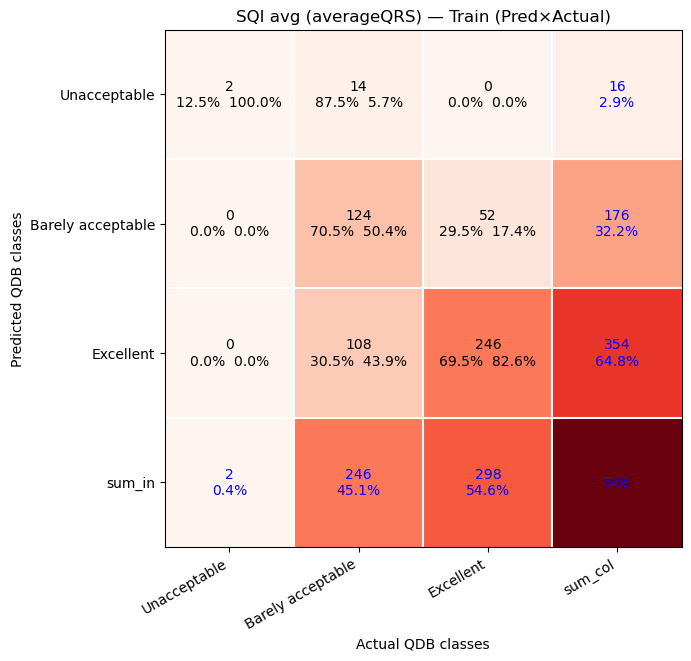

                   precision    recall  f1-score   support

     Unacceptable       0.12      1.00      0.22         2
Barely acceptable       0.70      0.50      0.59       246
        Excellent       0.69      0.83      0.75       298

         accuracy                           0.68       546
        macro avg       0.51      0.78      0.52       546
     weighted avg       0.70      0.68      0.68       546

[SQI avg (averageQRS)] Test confusion:


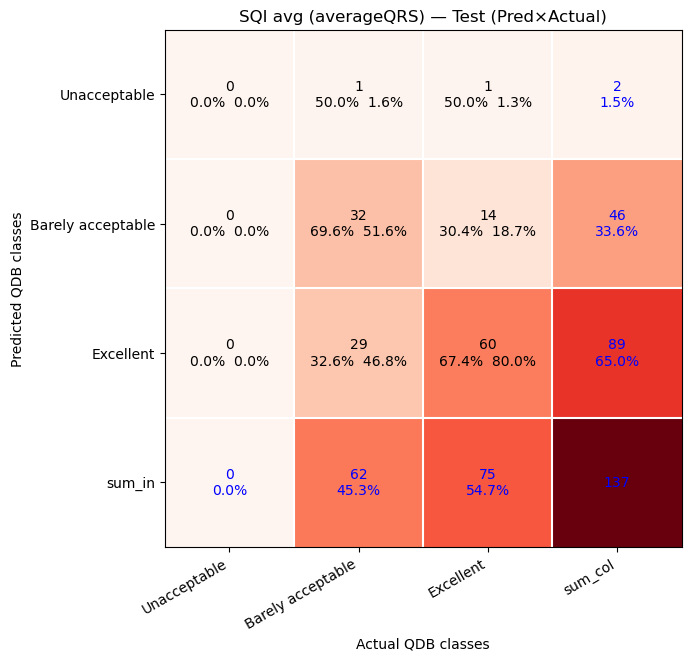

                   precision    recall  f1-score   support

     Unacceptable       0.00      0.00      0.00         0
Barely acceptable       0.70      0.52      0.59        62
        Excellent       0.67      0.80      0.73        75

         accuracy                           0.67       137
        macro avg       0.46      0.44      0.44       137
     weighted avg       0.68      0.67      0.67       137

[SQI avg (averageQRS)] Test macro-F1: 0.441


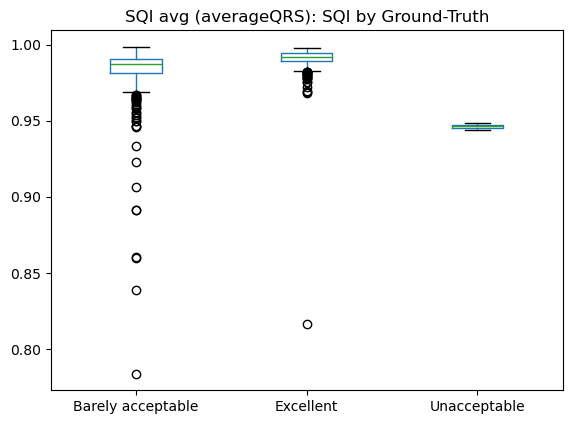

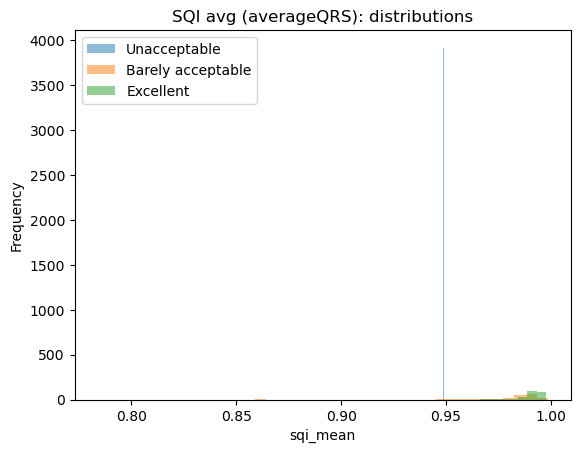


=== Morph Corr ===


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encounte

[SQI Morph Corr] thresholds (train): t1=0.348, t2=0.989
[SQI Morph Corr] Train confusion:


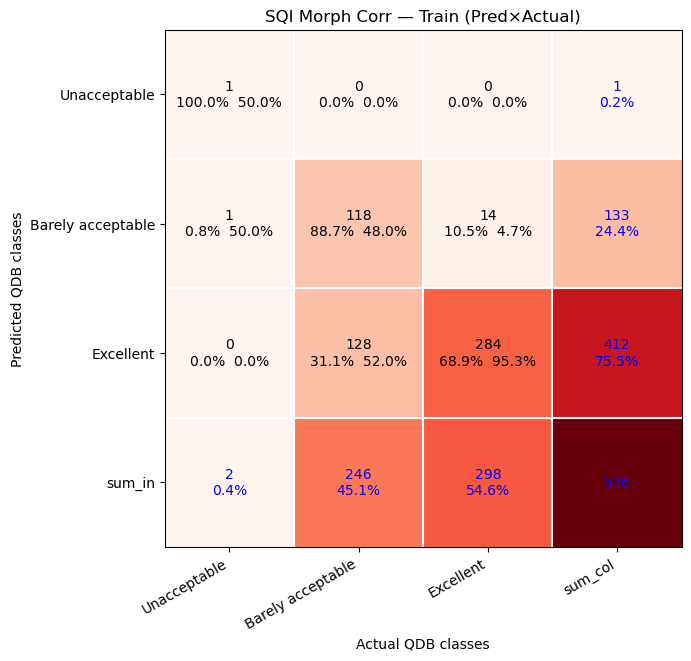

                   precision    recall  f1-score   support

     Unacceptable       1.00      0.50      0.67         2
Barely acceptable       0.89      0.48      0.62       246
        Excellent       0.69      0.95      0.80       298

         accuracy                           0.74       546
        macro avg       0.86      0.64      0.70       546
     weighted avg       0.78      0.74      0.72       546

[SQI Morph Corr] Test confusion:


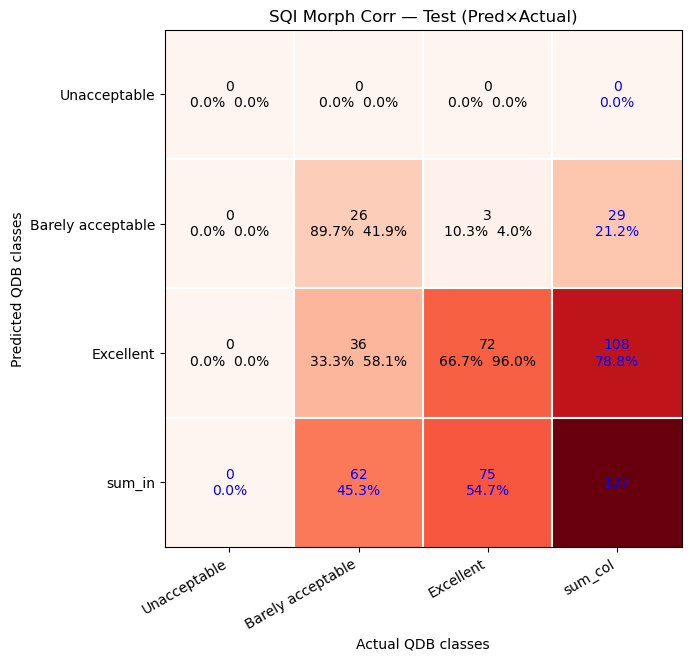

                   precision    recall  f1-score   support

     Unacceptable       0.00      0.00      0.00         0
Barely acceptable       0.90      0.42      0.57        62
        Excellent       0.67      0.96      0.79        75

         accuracy                           0.72       137
        macro avg       0.52      0.46      0.45       137
     weighted avg       0.77      0.72      0.69       137

[SQI Morph Corr] Test macro-F1: 0.453


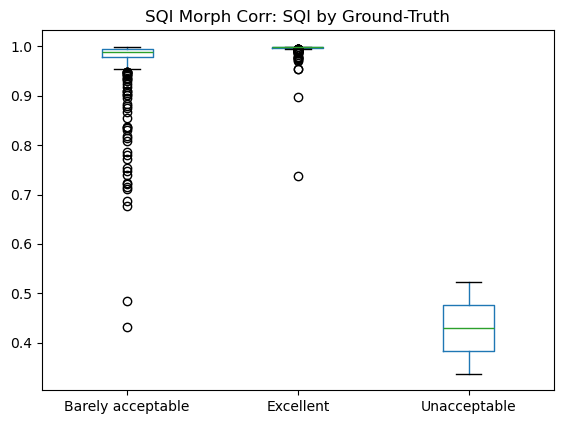

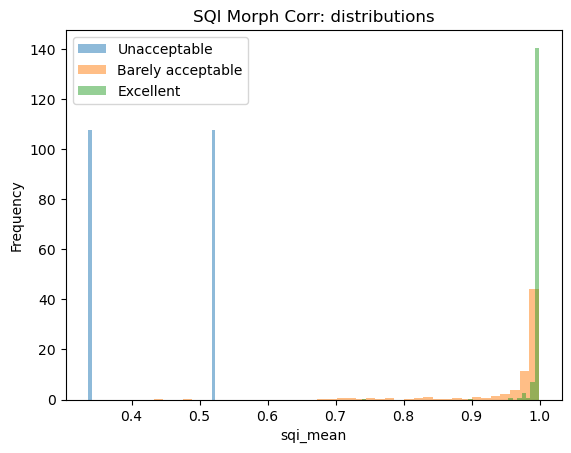


=== HRV (local median tol) ===


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encountered in divide
  f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7412\2583553268.py:60: RuntimeWarning: invalid value encounte

[SQI HRV] thresholds (train): t1=0.000, t2=0.017
[SQI HRV] Train confusion:


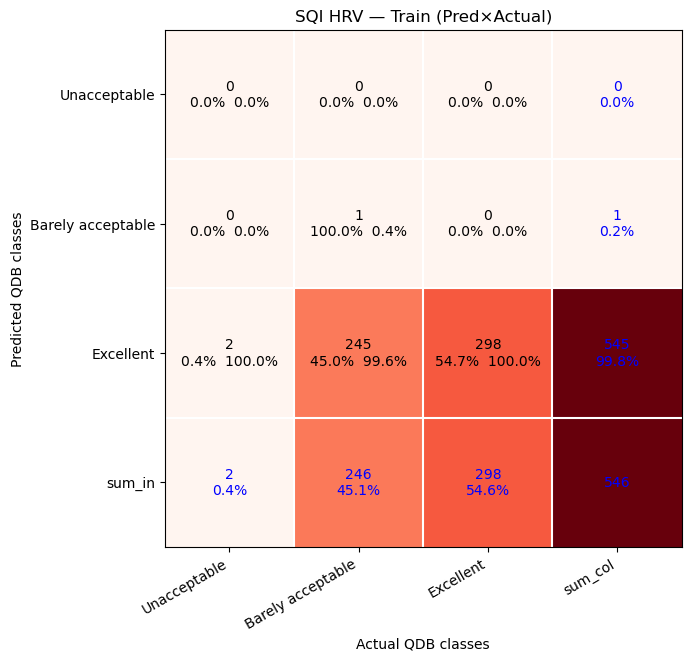

                   precision    recall  f1-score   support

     Unacceptable       0.00      0.00      0.00         2
Barely acceptable       1.00      0.00      0.01       246
        Excellent       0.55      1.00      0.71       298

         accuracy                           0.55       546
        macro avg       0.52      0.33      0.24       546
     weighted avg       0.75      0.55      0.39       546

[SQI HRV] Test confusion:


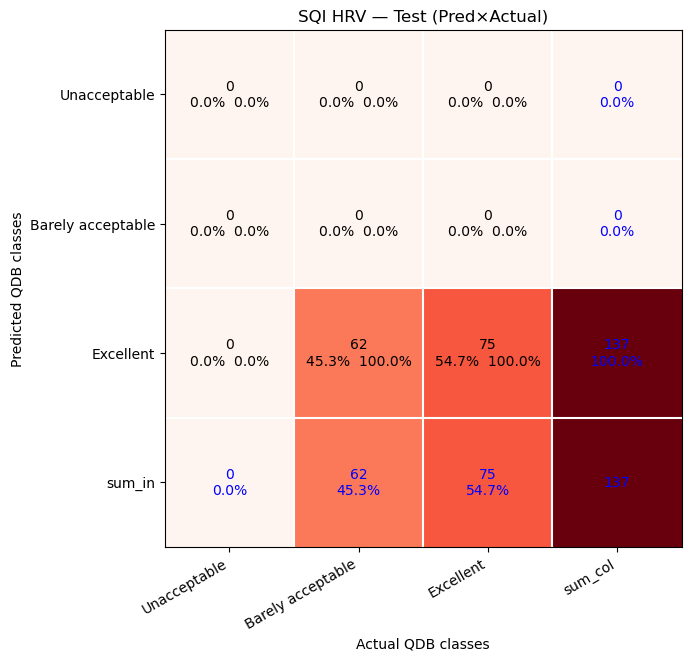

                   precision    recall  f1-score   support

     Unacceptable       0.00      0.00      0.00         0
Barely acceptable       0.00      0.00      0.00        62
        Excellent       0.55      1.00      0.71        75

         accuracy                           0.55       137
        macro avg       0.18      0.33      0.24       137
     weighted avg       0.30      0.55      0.39       137

[SQI HRV] Test macro-F1: 0.236


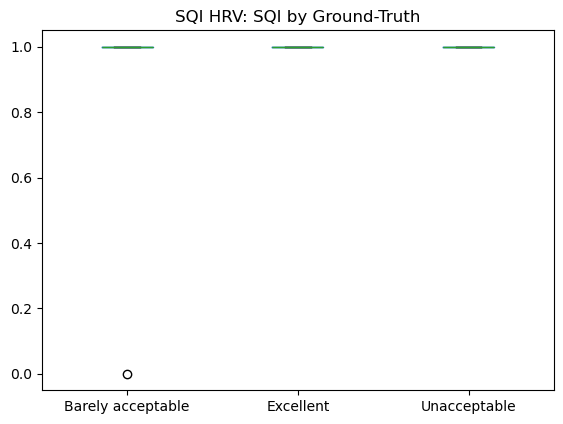

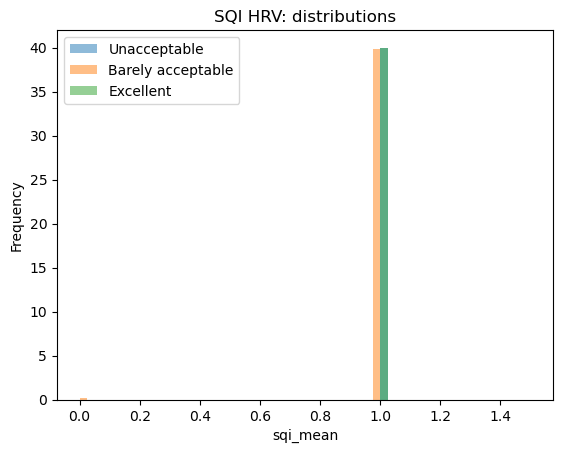


=== zhao2018 (segment-wise) ===


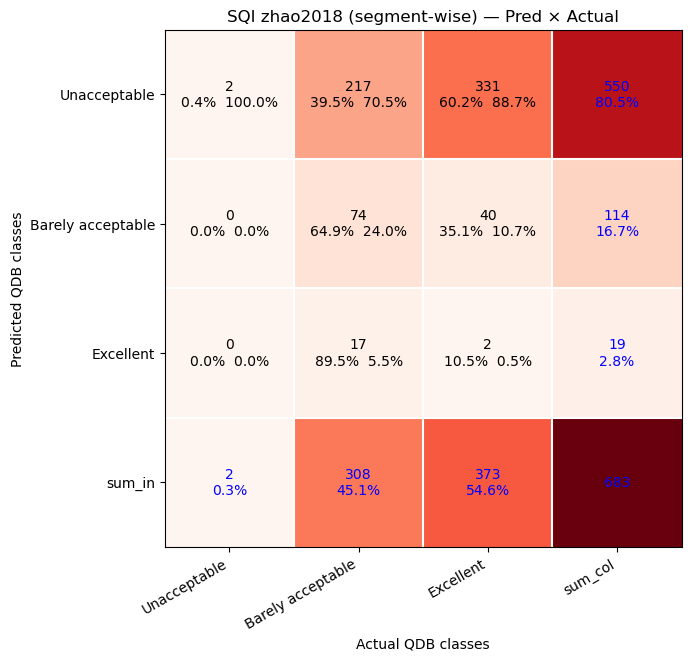

                   precision    recall  f1-score   support

     Unacceptable       0.00      1.00      0.01         2
Barely acceptable       0.65      0.24      0.35       308
        Excellent       0.11      0.01      0.01       373

         accuracy                           0.11       683
        macro avg       0.25      0.42      0.12       683
     weighted avg       0.35      0.11      0.16       683

[zhao2018] macro-F1: 0.123


In [35]:
# ======================
# KØR HER (tilpas parametre efter behov)
# ======================
# Eksempel:
results = run_sqi_eval_all(
    ecg=raw_signal,
    fs=fs,                        # fx 1000
    segments=segments,            # [(start,end), ...] i samples (eller seconds + units="seconds")
    labels=labels,                # én pr. segment (1/2/3 eller tekst)
    units="samples",
    min_beats=3,
    agg="median",
    clean_method="neurokit",      # prøv evt. "biosppy" og sammenlign
    qrs_win=(0.18, 0.22),         # test evt. (0.12,0.18)
    hrv_tol=0.12, hrv_win=7
)

In [39]:
# === Alt-i-én celle: beregn SQI'er, aggreger pr. segment, fit grænser, evaluer ===
import numpy as np, pandas as pd, neurokit2 as nk, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ---------- 0) Hjælpere ----------
CLASSES = ["Unacceptable", "Barely acceptable", "Excellent"]

def canon_label(x):
    """Map dine labels til ens tekstklasser."""
    if x is None: return None
    s = str(x).strip().lower()
    if s in {"0","unacceptable","bad","poor"}: return "Unacceptable"
    if s in {"1","barely acceptable","medium","moderate","2"}: return "Barely acceptable"
    if s in {"2","3","excellent","good"}: return "Excellent"
    return None

def class_to_int(c):
    return {"Unacceptable":0, "Barely acceptable":1, "Excellent":2}.get(c, -1)

def classify_with_thresholds(x, t1, t2, nan_is=None):
    """Kontinuer til 3 klasser med to grænser."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return nan_is
    if x < t1: return "Unacceptable"
    if x < t2: return "Barely acceptable"
    return "Excellent"

def confusion_like_paper(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=CLASSES)
    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
    disp.plot(cmap="Reds", ax=ax, colorbar=False, values_format="d")
    ax.set_title(title)
    plt.tight_layout(); plt.show()
    print(classification_report(y_true, y_pred, labels=CLASSES, zero_division=0))

# ---------- 1) Peaks + pr-beat SQI'er ----------
def compute_peaks_and_clean(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = info["ECG_R_Peaks"].astype(int)
    # valgfrit: fix peaks (kan hjælpe HRV)
    r, _ = nk.signal_fixpeaks(r, sampling_rate=fs, iterative=True, show=False)
    return ecg_clean, r

def sqi_averageqrs_perbeat(ecg_clean, r, fs):
    # NeuroKit giver pr-beat quality for method="averageQRS"
    q = nk.ecg_quality(ecg_clean, rpeaks=r, sampling_rate=fs, method="averageQRS")
    q = np.asarray(q, float)
    # klip til [0,1]
    q = np.clip(q, 0, 1)
    return q

def sqi_morphcorr_perbeat(ecg_clean, r, fs, w_ms=120):
    """Korrelation af hver QRS mod median-skabelon."""
    w = int(round((w_ms/1000)*fs//2))  # +/- w samples
    # udtræk små QRS-udsnit
    beats = []
    for rp in r:
        a, b = rp-w, rp+w
        if a>=0 and b < len(ecg_clean):
            beats.append(ecg_clean[a:b+1])
    if len(beats) < 5:
        return np.full(r.shape[0], np.nan)
    A = np.vstack(beats)
    template = np.nanmedian(A, axis=0)
    # normalisér
    t = (template - np.nanmean(template))
    t /= (np.nanstd(t)+1e-8)
    scores = np.full(len(r), np.nan)
    k = 0
    for i, rp in enumerate(r):
        a, b = rp-w, rp+w
        if a>=0 and b < len(ecg_clean):
            seg = ecg_clean[a:b+1]
            seg = (seg - np.nanmean(seg)) / (np.nanstd(seg)+1e-8)
            corr = np.nan_to_num(np.dot(seg, t) / (len(t)))
            # skaler til [0,1]
            scores[i] = (corr + 1)/2
            k += 1
    return scores

def sqi_hrv_perbeat(r, fs, k_tol=0.10, win_beats=7):
    """HRV-SQI: 1 hvis RR ~ lokal median, ellers lavere.
       Returnér pr-beat score i [0,1].
    """
    if len(r) < 3:
        return np.full(len(r), np.nan)
    rr = np.diff(r) / fs  # sek
    # lokal median over glidende vindue
    from collections import deque
    med = np.full_like(rr, np.nan, dtype=float)
    dq = deque(maxlen=win_beats)
    for i in range(len(rr)):
        dq.append(rr[i])
        med[i] = np.nanmedian(dq)
    # relativ afvigelse
    rel = np.abs(rr - med) / (np.maximum(med, 1e-6))
    s = 1.0 - np.clip(rel / k_tol, 0, 1)  # 1 når tæt på median, 0 når langt fra
    # læg en NaN i starten så længden matcher antal r-peaks
    return np.concatenate([[np.nan], s])

# ---------- 2) Aggregér pr segment ----------
def aggregate_by_segments(perbeat_values, r_idx, segments, labels, min_beats=3, agg="median"):
    rows = []
    for i, (s0, s1) in enumerate(segments):
        y = canon_label(labels[i]) if labels is not None else None
        # vælg de r-peaks der ligger i segmentet
        m = (r_idx >= s0) & (r_idx <= s1)
        vals = perbeat_values[m]
        vals = vals[np.isfinite(vals)]
        if vals.size >= min_beats:
            seg_q = float(np.nanmedian(vals) if agg=="median" else np.nanmean(vals))
        else:
            seg_q = np.nan
        rows.append({"seg_id": i, "start": s0, "end": s1, "label_true": y, "sqi_mean": seg_q, "n_beats": int(vals.size)})
    return pd.DataFrame(rows)

# ---------- 3) Fit (t1,t2) via grid ----------
def fit_t1_t2(y_true, scores):
    y = np.array([class_to_int(c) for c in y_true])
    s = np.array(scores, float)
    ok = np.isfinite(s) & (y>=0)
    y, s = y[ok], s[ok]
    if y.size == 0:
        return 0.33, 0.66  # fallback
    best = (0.33, 0.66, -1.0)
    for t1 in np.linspace(0.10, 0.60, 11):
        for t2 in np.linspace(t1+0.05, 0.95, 11):
            yp = np.array([class_to_int(classify_with_thresholds(v, t1, t2)) for v in s])
            # macro-F1
            from sklearn.metrics import f1_score
            f1 = f1_score(y, yp, labels=[0,1,2], average="macro", zero_division=0)
            if f1 > best[2]:
                best = (t1, t2, f1)
    return best[0], best[1]

# ---------- 4) Kør alt ----------
def run_all(ecg, fs, segments, labels,
            hrv_grid=( (0.08,7), (0.10,7), (0.10,9), (0.12,9) ),
            min_beats=3, agg="median", test_size=0.25, random_state=42):

    # peaks + pr-beat scores
    ecg_clean, r = compute_peaks_and_clean(ecg, fs)
    q_avg  = sqi_averageqrs_perbeat(ecg_clean, r, fs, batch_beats=8000, pre_s=0.18, post_s=0.22)
    q_morf = sqi_morphcorr_perbeat(ecg_clean, r, fs)
    results = {}

    # Lav DataFrames for hver metode
    df_avg  = aggregate_by_segments(q_avg,  r, segments, labels, min_beats, agg)
    df_morf = aggregate_by_segments(q_morf, r, segments, labels, min_beats, agg)

    # HRV: prøv flere parametre og vælg bedst på train
    best_hrv = None
    best_rep = None
    for k_tol, w in hrv_grid:
        q_hrv = sqi_hrv_perbeat(r, fs, k_tol=k_tol, win_beats=w)
        df_hrv = aggregate_by_segments(q_hrv, r, segments, labels, min_beats, agg)

        # split (stratificeret)
        d = df_hrv.dropna(subset=["label_true", "sqi_mean"]).copy()
        X = d[["sqi_mean"]].values
        y = d["label_true"].apply(canon_label)
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

        t1, t2 = fit_t1_t2(y_tr, X_tr.ravel())
        y_pred = [classify_with_thresholds(v, t1, t2) for v in X_te.ravel()]

        from sklearn.metrics import f1_score
        f1 = f1_score([class_to_int(c) for c in y_te], [class_to_int(c) for c in y_pred],
                      labels=[0,1,2], average="macro", zero_division=0)
        if (best_hrv is None) or (f1 > best_hrv[0]):
            best_hrv = (f1, k_tol, w, t1, t2)
            best_rep = (y_te, y_pred, d, t1, t2)

    # Eval-funktion for numeric metoder (avg, morph, hrv_best)
    def eval_numeric(df, name, t1=None, t2=None):
        d = df.dropna(subset=["label_true", "sqi_mean"]).copy()
        X = d[["sqi_mean"]].values
        y = d["label_true"].apply(canon_label)
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
        if t1 is None or t2 is None:
            t1, t2 = fit_t1_t2(y_tr, X_tr.ravel())
        y_pred = [classify_with_thresholds(v, t1, t2) for v in X_te.ravel()]
        print(f"\n=== {name} === (t1={t1:.2f}, t2={t2:.2f})")
        confusion_like_paper(list(y_te), y_pred, f"{name} — Pred × Actual")
        return {"name":name, "t1":t1, "t2":t2}

    # averageQRS
    results["avgQRS"]  = eval_numeric(df_avg,  "SQI avg (averageQRS)")
    # morph corr
    results["morph"]   = eval_numeric(df_morf, "SQI Morph Corr")
    # HRV (bedste)
    y_te, y_pred, d_hrv, t1_b, t2_b = best_rep
    print(f"\n=== SQI HRV (best k_tol={best_hrv[1]}, win={best_hrv[2]}) === (t1={t1_b:.2f}, t2={t2_b:.2f})")
    confusion_like_paper(list(y_te), y_pred, f"SQI HRV — Pred × Actual")
    results["hrv"] = {"name":"SQI HRV", "k_tol":best_hrv[1], "win":best_hrv[2], "t1":t1_b, "t2":t2_b}

    # zhao2018 (segment-wise): få direkte labels, tag majoritet i hvert segment
    zh = nk.ecg_quality(ecg_clean, sampling_rate=fs, method="zhao2018")
    # zh er et array af labels pr. sample; vi nedkoger til segment-majoritet:
    def major_label(s0, s1):
        v = pd.Series(zh[s0:s1+1]).dropna().astype(str)
        if v.empty: return None
        # map til vores tre
        v = v.str.replace("excellent", "Excellent", case=False)\
             .str.replace("barely acceptable","Barely acceptable", case=False)\
             .str.replace("unacceptable","Unacceptable", case=False)
        return v.value_counts().idxmax()

    rows = []
    for i,(s0,s1) in enumerate(segments):
        rows.append({"seg_id":i,
                     "label_true": canon_label(labels[i]),
                     "label_pred": major_label(s0,s1)})
    df_zh = pd.DataFrame(rows).dropna()
    print("\n=== SQI zhao2018 (segment-wise) ===")
    confusion_like_paper(list(df_zh["label_true"]), list(df_zh["label_pred"]),
                         "SQI zhao2018 (segment-wise) — Pred × Actual")

    # Samlet overblik
    print("\nParams valgt:")
    for k,v in results.items():
        print(k, v)
    return results


# --- PATCH: robust håndtering af peaks -> indekser ---
def _to_rpeaks_idx(peaks, n_samples=None):
    """
    Accepterer forskellige peak-formater (indekser, dict, binær vektor) og returnerer indekser (np.int64).
    """
    import numpy as np

    # liste/array af heltal -> allerede indekser
    arr = np.asarray(peaks)
    if np.issubdtype(arr.dtype, np.integer):
        return arr.astype(int)

    # dict med forskellige keys
    if isinstance(peaks, dict):
        for key in ("ECG_R_Peaks", "R_Peaks", "Peaks"):
            if key in peaks:
                v = np.asarray(peaks[key])
                if np.issubdtype(v.dtype, np.integer):
                    return v.astype(int)
                # binær/bool til indekser
                if v.dtype == bool or set(np.unique(v)).issubset({0,1}):
                    return np.where(v)[0].astype(int)

    # binær/bool vektor i fuld signal-længde
    if arr.dtype == bool or set(np.unique(arr)).issubset({0,1}):
        return np.where(arr)[0].astype(int)

    # fallback (prøv at caste til int)
    return arr.astype(int)


def compute_peaks_and_clean(ecg, fs, use_fixpeaks=True):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r = _to_rpeaks_idx(info["ECG_R_Peaks"], n_samples=len(ecg_clean))

    if use_fixpeaks:
        try:
            fixed, _ = nk.signal_fixpeaks(r, sampling_rate=fs, iterative=True, show=False)
            r = _to_rpeaks_idx(fixed, n_samples=len(ecg_clean))  # <<< konverter TIL INDEKSER
        except Exception as e:
            print("[warn] signal_fixpeaks blev sprunget over:", e)

    return ecg_clean, r

    # --- DROP-IN PATCH: averageQRS i batches (løser MemoryError) ---

def _avgqrs_one_batch(ecg_clean, r_local, fs, pre_s=0.18, post_s=0.22):
    """Kør NK averageQRS på et lokalt udsnit og lokale rpeaks."""
    return np.asarray(
        nk.ecg_quality(ecg_clean, rpeaks=r_local, sampling_rate=fs, method="averageQRS"),
        float
    )

def sqi_averageqrs_perbeat_batched(ecg_clean, r, fs,
                                   batch_beats=8000,  # justér 5k–15k efter RAM
                                   pre_s=0.18, post_s=0.22):
    """
    Returnér per-beat averageQRS-scorer ved at køre i batches.
    pre_s/post_s bruges kun til at definere hvor meget signal vi klipper ud omkring batchen.
    """
    n = len(r)
    if n == 0:
        return np.array([]), r

    pre = int(round(pre_s * fs))
    post = int(round(post_s * fs))
    L = len(ecg_clean)

    out = np.empty(n, dtype=float)
    start = 0
    while start < n:
        stop = min(start + batch_beats, n)

        # dæk vindue fra første til sidste beat i batchen (+ margin)
        left  = max(0, r[start] - pre)
        right = min(L - 1, r[stop - 1] + post)

        ecg_seg = ecg_clean[left:right + 1]
        r_local = r[start:stop] - left  # lokalt indeks i udsnittet

        # Kør NK på batchen
        q_local = _avgqrs_one_batch(ecg_seg, r_local, fs, pre_s=pre_s, post_s=post_s)

        # Længden af q_local skal matche antal beats i batchen
        if len(q_local) != (stop - start):
            # defensive fallback: pad/trim hvis NK smider kantbeats
            k = min(len(q_local), stop - start)
            out[start:start + k] = q_local[:k]
            if k < (stop - start):
                out[start + k:stop] = np.nan
        else:
            out[start:stop] = q_local

        start = stop

    # klip til [0,1] for robusthed
    out = np.clip(out, 0, 1)
    return out, r

# Brug batch-varianten automatisk (fanger MemoryError)
def sqi_averageqrs_perbeat(ecg_clean, r, fs,
                           batch_beats=8000, pre_s=0.18, post_s=0.22):
    try:
        q = nk.ecg_quality(ecg_clean, rpeaks=r, sampling_rate=fs, method="averageQRS")
        q = np.asarray(q, float)
        if q.shape[0] != r.shape[0]:
            raise MemoryError("epoch mis-match → brug batched")
        return np.clip(q, 0, 1)
    except MemoryError:
        print("[info] averageQRS: MemoryError → skifter til batched kørsel …")
        q, _ = sqi_averageqrs_perbeat_batched(ecg_clean, r, fs,
                                              batch_beats=batch_beats,
                                              pre_s=pre_s, post_s=post_s)
        return q



# ---------- Kør på dine data ----------
_ = run_all(raw_signal, fs, segments, labels,
            hrv_grid=((0.08,7),(0.10,7),(0.10,9),(0.12,9),(0.15,9)),
            min_beats=3, agg="median", test_size=0.25, random_state=42)


[warn] signal_fixpeaks blev sprunget over: unhashable type: 'dict'
[info] averageQRS: MemoryError → skifter til batched kørsel …


KeyboardInterrupt: 